In [4]:
from feature_engine.imputation import MeanMedianImputer
import pickle
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score, accuracy_score, log_loss
from sklearn.preprocessing import label_binarize

from datetime import datetime, timedelta
import holidays

from tqdm import tqdm_notebook, tqdm
import warnings
from sklearn.exceptions import ConvergenceWarning
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

warnings.simplefilter('ignore')
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=ConvergenceWarning)

seed = 42
np.random.seed(seed)

In [5]:
def calculate_auuq(y_true, y_pred_proba):
    """
    Функция для вычисления Area Under Uplift Curve (AUUQ).
    
    Параметры:
    y_true (numpy.ndarray или pandas.Series): Истинные ответы, shape (n_samples,)
    y_pred_proba (numpy.ndarray): Предсказанные вероятности, shape (n_samples,)
    
    Возвращает:
    float: Значение AUUQ
    """
    # Сортируем по вероятностям
    sorted_indices = np.argsort(y_pred_proba)[::-1]
    
    try:
        # Используем iloc для позиционного индексирования
        y_true_sorted = y_true.iloc[sorted_indices]
    except KeyError as e:
        print(f"KeyError encountered: {e}")
        return None  # Или обработайте это как нужно
    
    # Вычисляем кумулятивные суммы
    cumulative_gain = np.cumsum(y_true_sorted)
    
    # Вычисляем AUUQ
    total_positive = np.sum(y_true)
    
    if total_positive == 0:  # Проверка на деление на ноль
        return 0.0
    
    auuq = cumulative_gain / total_positive
    
    return np.mean(auuq)

def evaluate_models(models, model_names, X, Y) -> pd.DataFrame:
    """
    Функция для оценки списка моделей по метрикам точности, F1, полноты, точности, ROC AUC, Gini, Log Loss и AUUQ.
    
    Параметры:
    models (list): Список обученных моделей
    model_names (list): Список названий моделей
    X (numpy.ndarray): Набор данных для предсказания, shape (n_samples, n_features)
    Y (numpy.ndarray): Истинные ответы, shape (n_samples,)
    
    Возвращает:
    pandas.DataFrame: Таблица с метриками для каждой модели
    """
    
    if len(models) != len(model_names):
        raise ValueError("Списки моделей и названий моделей должны быть одинаковой длины")
    
    results = []
    
    for model, name in zip(models, model_names):
        y_pred = model.predict(X)
        accuracy = accuracy_score(Y, y_pred)
        f1 = f1_score(Y, y_pred)
        recall = recall_score(Y, y_pred)
        precision = precision_score(Y, y_pred)
        
        # Вычисление предсказания вероятностей для метрик ROC AUC и Gini
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X)[:, 1]
            roc_auc = roc_auc_score(Y, y_proba)
            gini = 2 * roc_auc - 1
            logloss = log_loss(Y, y_proba)
            auuq = calculate_auuq(pd.Series(Y), y_proba)  # Преобразуем Y в Series для совместимости
        else:
            roc_auc = None
            gini = None
            logloss = None
            auuq = None
        
        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Recall': recall,
            'Precision': precision,
            'ROC AUC': roc_auc,
            'Gini': gini,
            'Log Loss': logloss,
            'AUUQ': auuq
        })
    
    results_df = pd.DataFrame(results)
    return results_df

In [6]:
def plot_roc_curve(model, X, Y):
    """
    Функция для построения ROC кривой и вывода метрики AUC.
    
    Параметры:
    model: обученная модель, которая поддерживает метод predict_proba
    X (numpy.ndarray): Набор данных для предсказания, shape (n_samples, n_features)
    Y (numpy.ndarray): Истинные ответы, shape (n_samples,)
    """
    # Получение предсказанных вероятностей для положительного класса (1)
    y_proba = model.predict_proba(X)[:, 1]

    # Вычисляем ROC кривую и AUC
    fpr, tpr, thresholds = roc_curve(Y, y_proba)
    roc_auc = roc_auc_score(Y, y_proba)

    # Строим график
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Линия для случайного угадывания
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [7]:
def reduce_mem_usage(df: pd.DataFrame) -> pd.DataFrame:
    """ Проходит по всем столбцам DataFrame и изменяет тип данных
        для уменьшения использования памяти.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name

        if col_type not in ['object', 'category', 'datetime64[ns, UTC]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [8]:
def process_dates(df, col_data):
    # Преобразуем серию в формат datetime
    dates = pd.to_datetime(df[col_data])

    # Определяем выходной или рабочий день (0 - рабочий, 1 - выходной)
    df['is_weekend'] = dates.dt.dayofweek >= 5  # Суббота и воскресенье
    df['is_weekend'] = df['is_weekend'].astype(int)  # Преобразуем в 0 и 1

    # Определяем время года (1 - зима, 2 - весна, 3 - лето, 4 - осень)
    df['season'] = np.select(
        [
            (dates.dt.month == 12) | (dates.dt.month <= 2),  # Декабрь, Январь, Февраль
            (dates.dt.month >= 3) & (dates.dt.month <= 5),   # Март, Апрель, Май
            (dates.dt.month >= 6) & (dates.dt.month <= 8),   # Июнь, Июль, Август
            (dates.dt.month >= 9) & (dates.dt.month <= 11)   # Сентябрь, Октябрь, Ноябрь
        ],
        [1, 2, 3, 4]
    )

    # Определяем день недели (1 - понедельник, ..., 7 - воскресенье)
    df['weekday'] = dates.dt.dayofweek + 1

    # Определяем номер месяца
    df['month'] = dates.dt.month

    # Определяем номер недели в месяце
    df['week_of_month'] = ((dates.dt.day - 1) // 7) + 1

    return df

# Анализ данных

## Просмотр

In [9]:
data = pd.read_csv('train_E.csv')
data

,application_1,cc_1,cc_2,cc_3,cc_4,feature_1,mb_1,cc_5,cc_6,feature_2,...,cc_21,application_15,feature_25,feature_26,cc_22,partner_24,application_16,retro_date,successful_utilization,treatment
0,NaN,1.0,Representatives,123.0,Первичная ДК,1,14.0,147000.0,PLT,0.0,...,NaN,0,1.0,0.0,-1.2,1.0,0,2024-07-04,0,1
1,NaN,1.0,Offline,43.0,Airports,0,1.0,120000.0,PLT,0.0,...,1.0,0,1.0,0.0,-1.2,1.0,0,2024-06-06,0,1
2,0.0,1.0,Web,2.0,seo,0,NaN,15000.0,PLT,0.0,...,NaN,0,NaN,0.0,-1.2,1.0,0,2024-07-21,1,1
3,0.0,1.0,MB,2.0,One Click Offer,0,91.0,260000.0,PLT,0.0,...,1.0,0,NaN,1.0,-1.2,1.0,0,2024-05-23,0,1
4,0.0,1.0,Representatives,123.0,Первичная ДК,1,1.0,130000.0,PLT,0.0,...,NaN,0,1.0,0.0,-1.2,1.0,0,2024-06-28,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297245,NaN,1.0,Representatives,123.0,Первичная ДК,1,34.0,95000.0,PLT,0.0,...,NaN,0,1.0,0.0,-1.2,1.0,0,2024-05-13,1,1
297246,NaN,1.0,Representatives,123.0,Первичная ДК,1,1.0,83000.0,PLT,0.0,...,NaN,0,1.0,0.0,-1.2,NaN,0,2024-07-08,0,1
297247,0.0,1.0,Mobile Warm,2.0,TOOS cor clients,0,2.0,170000.0,PLT,0.0,...,1.0,0,NaN,0.0,1.0,1.0,0,2024-06-12,0,1
297248,0.0,1.0,Representatives,123.0,Первичная ДК,1,5.0,15000.0,PLT,0.0,...,0.0,0,1.0,0.0,-1.2,1.0,0,2024-06-02,1,1


In [10]:
data.isna().sum()

application_1             115128
cc_1                       18235
cc_2                       10479
cc_3                       10479
cc_4                       10482
                           ...  
partner_24                 40468
application_16                 0
retro_date                     0
successful_utilization         0
treatment                      0
Length: 152, dtype: int64

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297250 entries, 0 to 297249
Columns: 152 entries, application_1 to treatment
dtypes: float64(131), int64(17), object(4)
memory usage: 344.7+ MB


## Очистка

In [9]:
data_del_par, nan_par_nums, nana_par_obj = [], [], []


for i in data.isnull().sum().items():
    if i[-1] > len(data) * 0.7:
        data_del_par.append(i[0])
        print(i)
    if 0 < i[-1] <= len(data) * 0.7 and data[i[0]].dtype != object:
        nan_par_nums.append(i[0])
    if 0 < i[-1] <= len(data) * 0.7 and data[i[0]].dtype == object:
        nana_par_obj.append(i[0])

('bki_20', 224048)
('feature_16', 278988)
('application_12', 217768)
('partner_22', 278303)
('feature_23', 284741)


In [10]:
data = data.drop(columns=data_del_par)

# imputer = MeanMedianImputer(imputation_method='mean', variables=nan_par_nums)
# imputer.fit(data[nan_par_nums])
# data[nan_par_nums] = imputer.transform(data[nan_par_nums])
for i in nan_par_nums:
    data[i] = data[i].fillna(-1)
for i in nana_par_obj:
    data[i] = data[i].fillna(data[i].mode()[0])

In [11]:
data.isna().sum()

application_1             0
cc_1                      0
cc_2                      0
cc_3                      0
cc_4                      0
                         ..
partner_24                0
application_16            0
retro_date                0
successful_utilization    0
treatment                 0
Length: 147, dtype: int64

## Object dtype

In [12]:
obj_dt = [i for i in data.columns if data[i].dtype == object]
len(obj_dt)

4

In [13]:
obj_dt

['cc_2', 'cc_4', 'cc_6', 'retro_date']

In [14]:
data[obj_dt[:3]]

,cc_2,cc_4,cc_6
0,Representatives,Первичная ДК,PLT
1,Offline,Airports,PLT
2,Web,seo,PLT
3,MB,One Click Offer,PLT
4,Representatives,Первичная ДК,PLT
...,...,...,...
297245,Representatives,Первичная ДК,PLT
297246,Representatives,Первичная ДК,PLT
297247,Mobile Warm,TOOS cor clients,PLT
297248,Representatives,Первичная ДК,PLT


cc_2
cc_2
Representatives                   212565
MB                                 24975
PreApprove (Mobile Applicants)     16500
Mobile Warm                        14573
Web                                13095
Offline                             7591
BAF (Приведи друга)                 5191
Down-sell                           2752
Mobile Cold                            5
Other                                  3
Name: count, dtype: int64
['Representatives' 'Offline' 'Web' 'MB' 'Down-sell' 'Mobile Warm'
 'PreApprove (Mobile Applicants)' 'BAF (Приведи друга)' 'Mobile Cold'
 'Other']
10


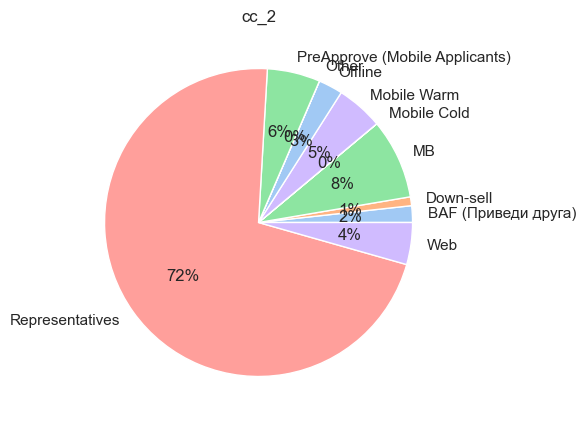


cc_4
cc_4
Первичная ДК       129549
Перевыпуск ДК       29989
Multitask           15941
One Click Offer      9183
Heavy                8413
                    ...  
smm                    11
afterfilling           10
Internet                7
Cold                    5
Installment             1
Name: count, Length: 75, dtype: int64
['Первичная ДК' 'Airports' 'seo' 'One Click Offer' 'Multitask'
 'Перевыпуск ДК' 'Cash Loan' 'Other' 'Установка приложения' 'SIM'
 'Доп.карта ДК' 'TOOS cor clients' 'Другое ДК' 'Heavy' 'affilate'
 'context' 'CCR Rescore (PA)' 'Heavy xsell' 'Страхование' 'Junior ДК'
 'Фейк встречи POS' 'TOOS afterfilling' 'TOOS other' 'Сразу полные'
 'LON Rescore (PA)' 'display' 'xsell_income_call_new' 'Rosbank'
 'COR Clients (PA)' 'pos_tcb_online' 'Инвестиции' 'Light'
 'POS Rescore (PA)' 'TOOS pos_trigger' 'other int' 'Phone' 'SME' 'sms'
 'Direct Car Loan' 'Partners' 'web_lk_organic' 'кошелек'
 'CC Attrition (PA)' 'cpa-bloggers' 'Own Retail' 'INV Clients (PA)'
 'TOOS cl_trig

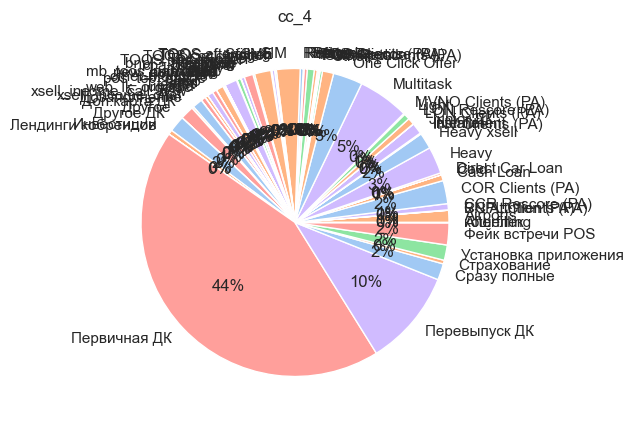


cc_6
cc_6
PLT    293395
AAR      3122
TDC       512
S7C       118
AGC        29
LKC        28
ALC        23
LMC        14
SCB         6
AAC         2
NON         1
Name: count, dtype: int64
['PLT' 'AAR' 'TDC' 'S7C' 'LKC' 'ALC' 'LMC' 'AGC' 'SCB' 'NON' 'AAC']
11


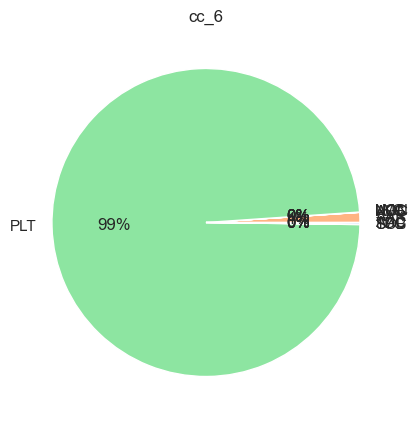


retro_date
retro_date
2024-05-05    5020
2024-05-09    4623
2024-05-06    4466
2024-04-29    4427
2024-06-06    4408
              ... 
2024-07-23    2137
2024-07-09    2093
2024-07-10    1876
2024-07-24    1830
2024-07-17    1825
Name: count, Length: 90, dtype: int64
['2024-07-04' '2024-06-06' '2024-07-21' '2024-05-23' '2024-06-28'
 '2024-06-29' '2024-06-21' '2024-06-09' '2024-06-14' '2024-06-08'
 '2024-05-03' '2024-06-17' '2024-07-18' '2024-05-27' '2024-05-15'
 '2024-06-20' '2024-05-09' '2024-05-01' '2024-05-10' '2024-05-21'
 '2024-05-07' '2024-06-25' '2024-07-15' '2024-06-24' '2024-07-22'
 '2024-05-17' '2024-07-11' '2024-07-03' '2024-06-30' '2024-05-12'
 '2024-06-04' '2024-05-30' '2024-05-24' '2024-07-25' '2024-06-13'
 '2024-05-14' '2024-07-09' '2024-06-16' '2024-04-30' '2024-05-04'
 '2024-06-27' '2024-05-18' '2024-05-08' '2024-07-08' '2024-07-16'
 '2024-06-11' '2024-07-01' '2024-05-31' '2024-05-06' '2024-04-29'
 '2024-07-07' '2024-06-22' '2024-07-19' '2024-06-03' '2024-05-02'
 '20

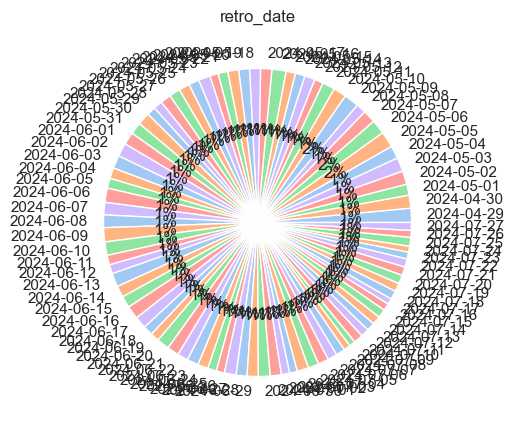

In [15]:
for elem in obj_dt:
    print(elem)
    print(data[elem].value_counts())
    print(data[elem].unique())
    print(len(data[elem].unique()))
    sns.set(rc={'figure.figsize': (5, 5)})
    colors = sns.color_palette('pastel')[0:5]
    labels = sorted(data[elem].map(str).unique())
    dt = np.array([len(data[data[elem] == i]) for i in labels])
    plt.pie(dt, labels=labels, colors=colors, autopct='%.0f%%')
    plt.title(elem)
    plt.show()
    print()

In [16]:
data = data.drop(columns=['cc_6'])

## Таргет

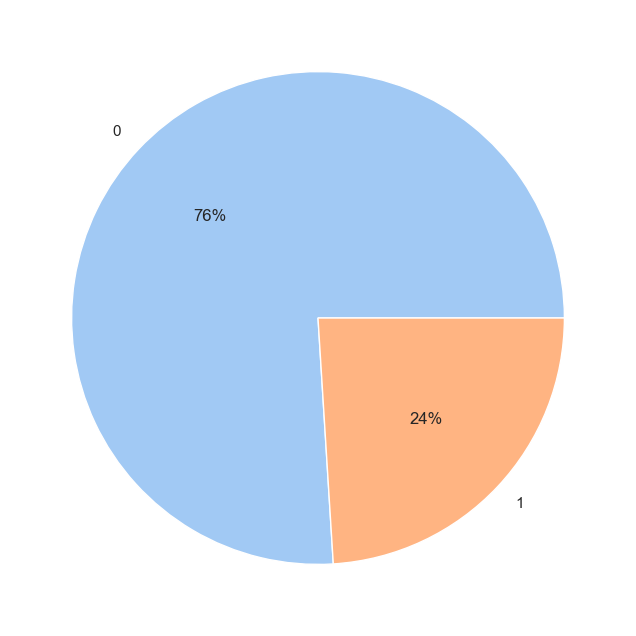

In [17]:
sns.set(rc={'figure.figsize': (15, 8)})
colors = sns.color_palette('pastel')[0:5]
labels = sorted(data['successful_utilization'].unique())
dt = np.array([len(data[data['successful_utilization'] == i])for i in labels])
plt.pie(dt, labels=labels, colors = colors, autopct='%.0f%%')
plt.show()

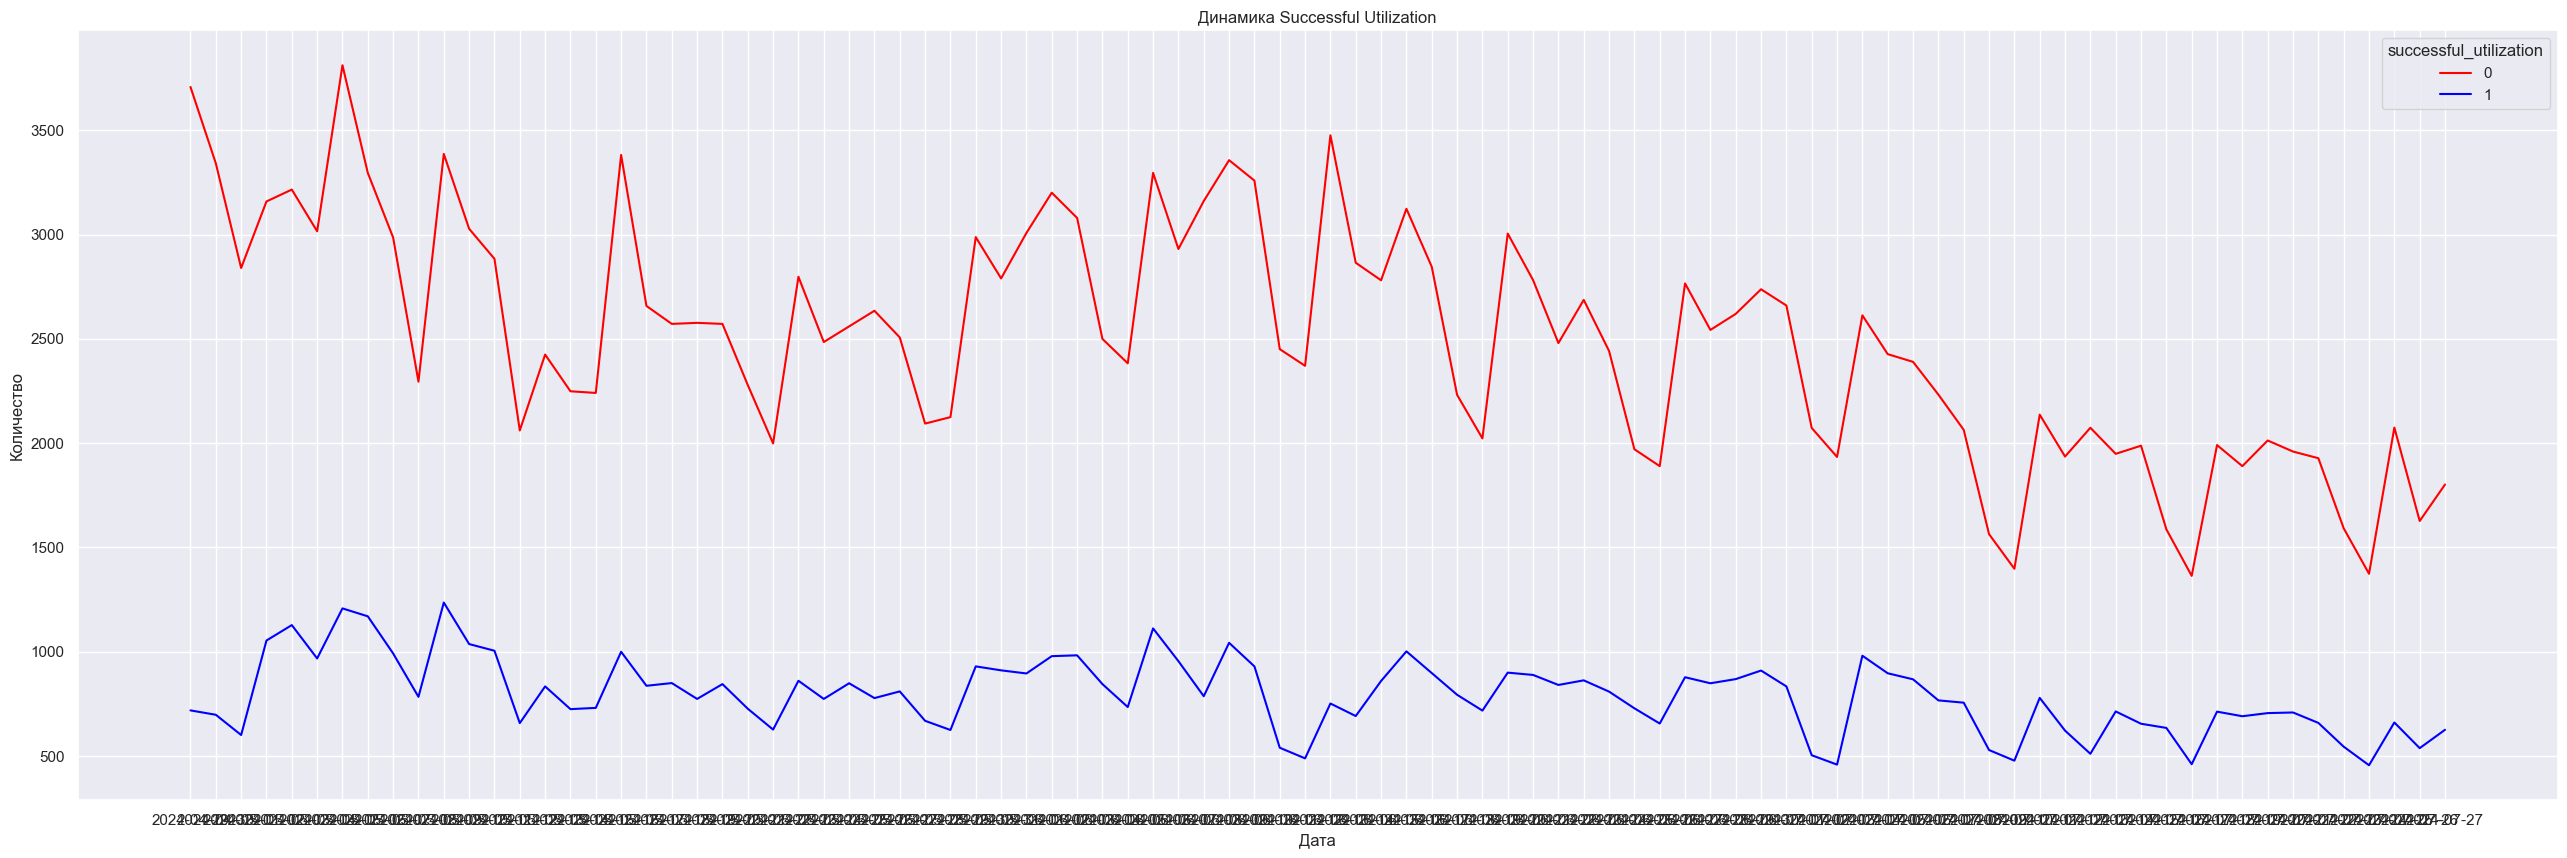

In [18]:
sns.set(rc={'figure.figsize': (32, 10)})

grouped_data = data.groupby(['retro_date', 'successful_utilization']).size().reset_index(name='count')

# Создаем график с двумя линиями
sns.lineplot(data=grouped_data, x='retro_date', y='count', hue='successful_utilization', palette=['red', 'blue'])

# Добавляем заголовок и метки осей
plt.title('Динамика Successful Utilization')
plt.xlabel('Дата')
plt.ylabel('Количество')

# Показываем график
plt.show()

<Axes: xlabel='retro_date', ylabel='count'>

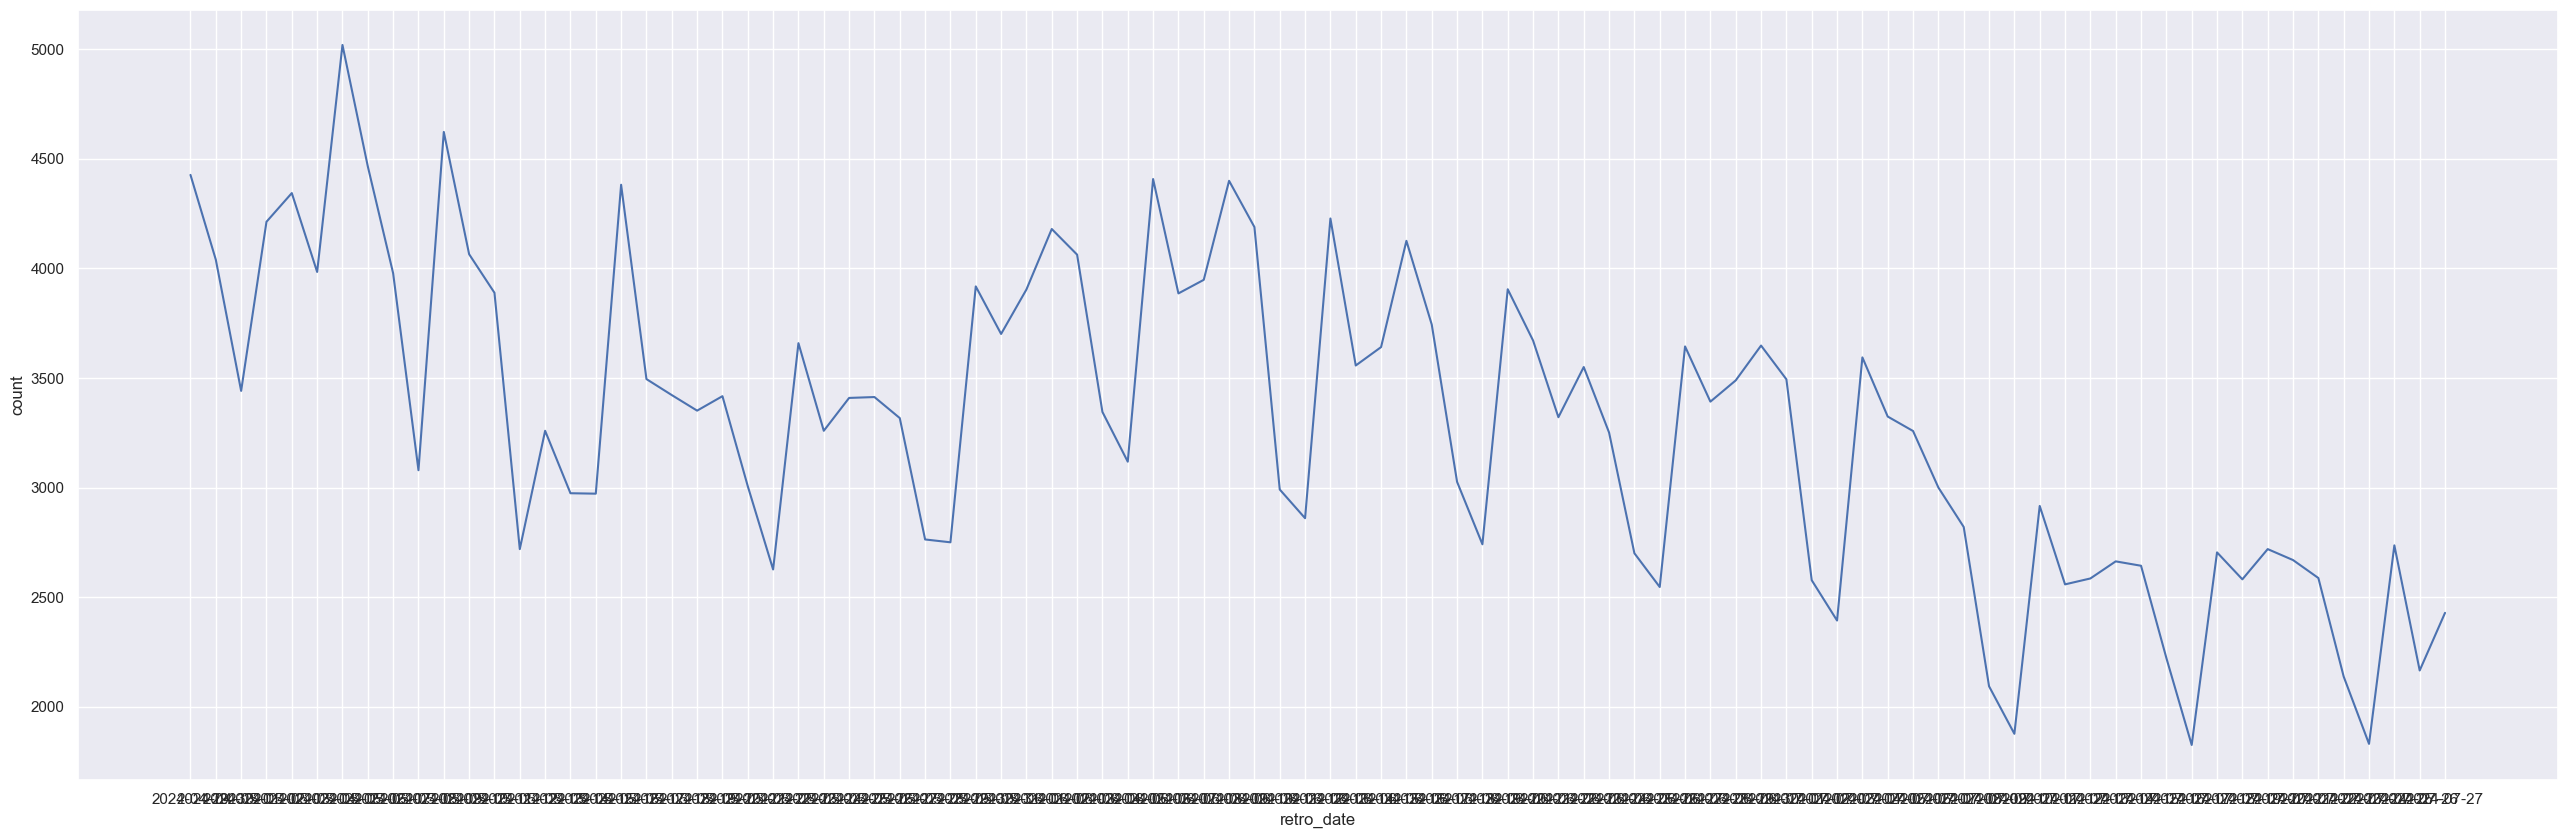

In [19]:
sns.set(rc={'figure.figsize': (32, 10)})

grouped_data = data.groupby(['retro_date']).size().reset_index(name='count')
sns.lineplot(data=grouped_data, x='retro_date', y='count')

## Посмотрим на дату, что можно сделать с ней и посмотрим на зависимости

In [20]:
data_cheker = data.copy()
data_cheker = process_dates(data_cheker, 'retro_date')

# data_cheker = process_dates(data, 'retro_date')

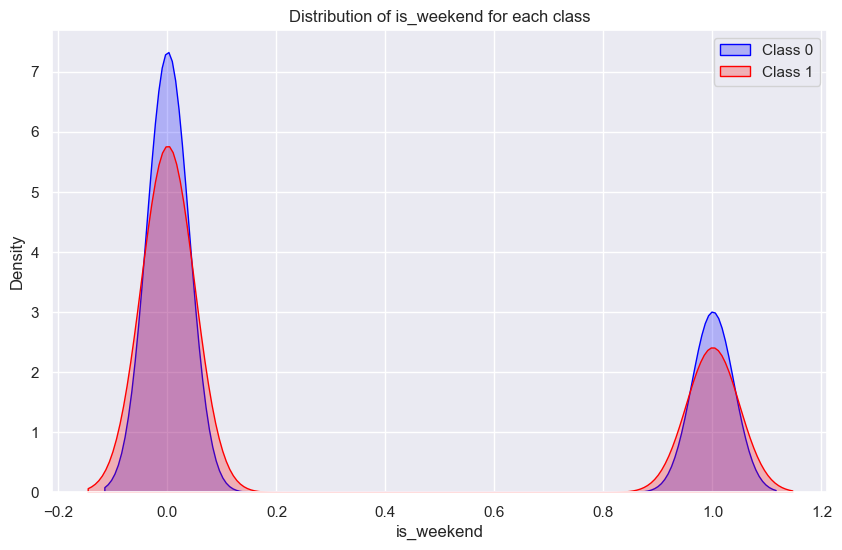

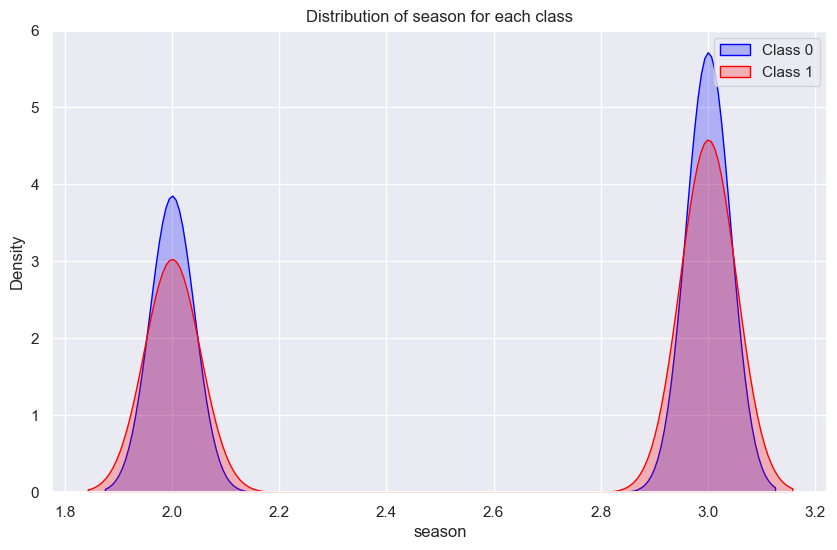

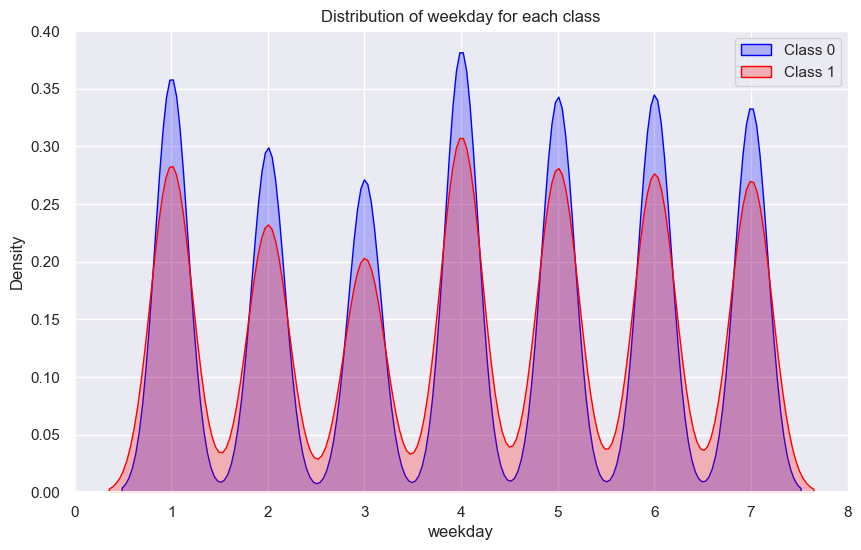

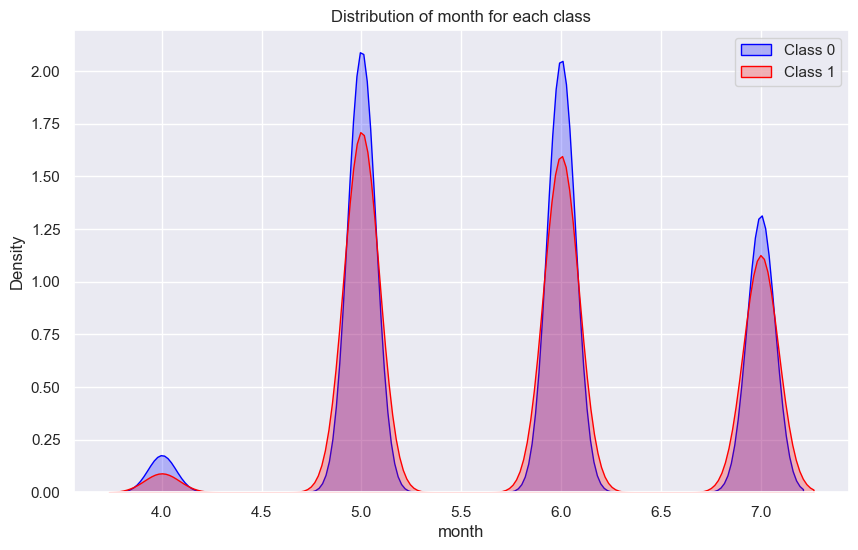

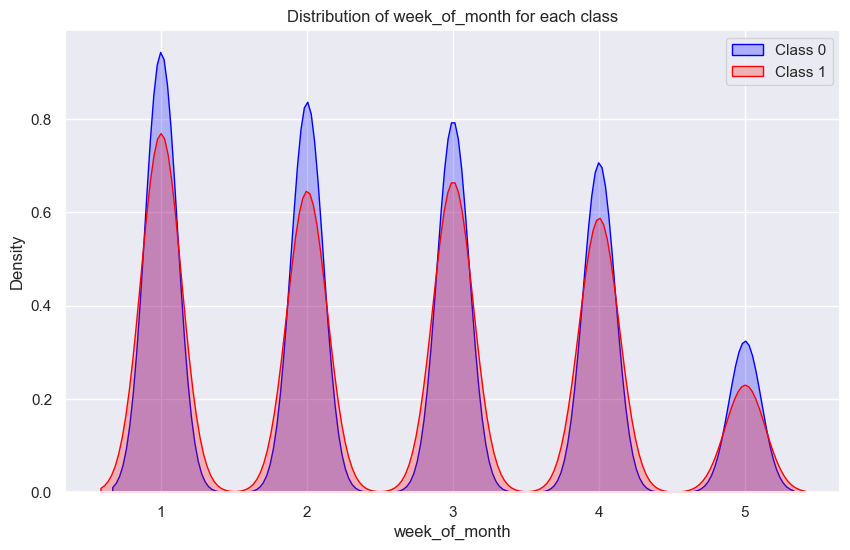

In [21]:
for i in data_cheker.iloc[:, -5:].columns:
    plt.figure(figsize=(10, 6))

    sns.kdeplot(data_cheker[data_cheker['successful_utilization'] == 0][i], label='Class 0', fill=True, color='blue')
    sns.kdeplot(data_cheker[data_cheker['successful_utilization'] == 1][i], label='Class 1', fill=True, color='red')

    # Настройки графика
    plt.title(f'Distribution of {i} for each class')
    plt.xlabel(i)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

In [22]:
data_cheker = 0

In [23]:
data = data.drop(columns=['retro_date'])

## Предабработаем тест

In [24]:
test = pd.read_csv('test_E.csv')

test = process_dates(test, 'retro_date')
test = test.drop(columns=data_del_par + ['cc_6', 'retro_date'])
test_nan_par_nums = []

for i in test.isnull().sum().items():
    if 0 < i[-1] <= len(test) * 0.7 and test[i[0]].dtype != object and i not in nan_par_nums:
        test_nan_par_nums.append(i[0])
    if 0 < i[-1] <= len(test) * 0.7 and test[i[0]].dtype == object:
        nana_par_obj.append(i[0])

# test[nan_par_nums] = imputer.transform(test[nan_par_nums])
for i in test_nan_par_nums + nan_par_nums:
    test[i] = test[i].fillna(0)
for i in [j for j in nana_par_obj if j in data.columns.tolist() and j in test.columns.tolist()]:
    test[i] = test[i].fillna(test[i].mode()[0])

In [25]:
test.isna().sum().sort_values()

application_1    0
bki_27           0
cc_17            0
bki_28           0
application_7    0
                ..
graph_2          0
feature_8        0
bki_11           0
bki_12           0
week_of_month    0
Length: 148, dtype: int64

In [26]:
test

,application_1,cc_1,cc_2,cc_3,cc_4,feature_1,mb_1,cc_5,feature_2,cc_7,...,feature_25,feature_26,cc_22,partner_24,application_16,is_weekend,season,weekday,month,week_of_month
0,0.0,1.0,Representatives,0.0,Первичная ДК,0,6.0,0.0,0.0,0.293391,...,0.0,0.0,-1.2,1.0,0,0,3,2,6,3
1,0.0,1.0,Representatives,0.0,Первичная ДК,0,45.0,0.0,0.0,0.001504,...,0.0,1.0,-1.2,1.0,0,0,2,4,5,2
2,0.0,1.0,MB,2.0,Heavy xsell,0,13.0,299000.0,0.0,0.025830,...,0.0,0.0,-1.2,1.0,0,0,2,4,5,5
3,0.0,1.0,Representatives,123.0,SIM,1,158.0,140000.0,0.0,0.004579,...,1.0,0.0,-1.2,1.0,0,0,2,1,5,4
4,0.0,1.0,Representatives,123.0,Первичная ДК,0,36.0,170000.0,0.0,0.034488,...,1.0,0.0,-1.2,1.0,0,1,3,6,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74308,0.0,1.0,Representatives,123.0,Multitask,1,0.0,15000.0,0.0,0.007608,...,1.0,0.0,-1.2,1.0,0,0,2,3,5,3
74309,0.0,1.0,Representatives,123.0,Первичная ДК,1,12.0,95000.0,0.0,0.019465,...,0.0,0.0,-1.2,1.0,0,0,3,3,7,2
74310,0.0,0.0,PreApprove (Mobile Applicants),2.0,Other,0,5.0,15000.0,0.0,0.000000,...,0.0,1.0,-1.2,1.0,1,0,3,4,6,4
74311,0.0,1.0,Representatives,123.0,Перевыпуск ДК,1,52.0,70000.0,0.0,0.001493,...,1.0,0.0,-1.2,1.0,0,0,3,1,6,2


## Корреляци и распределение

<Axes: >

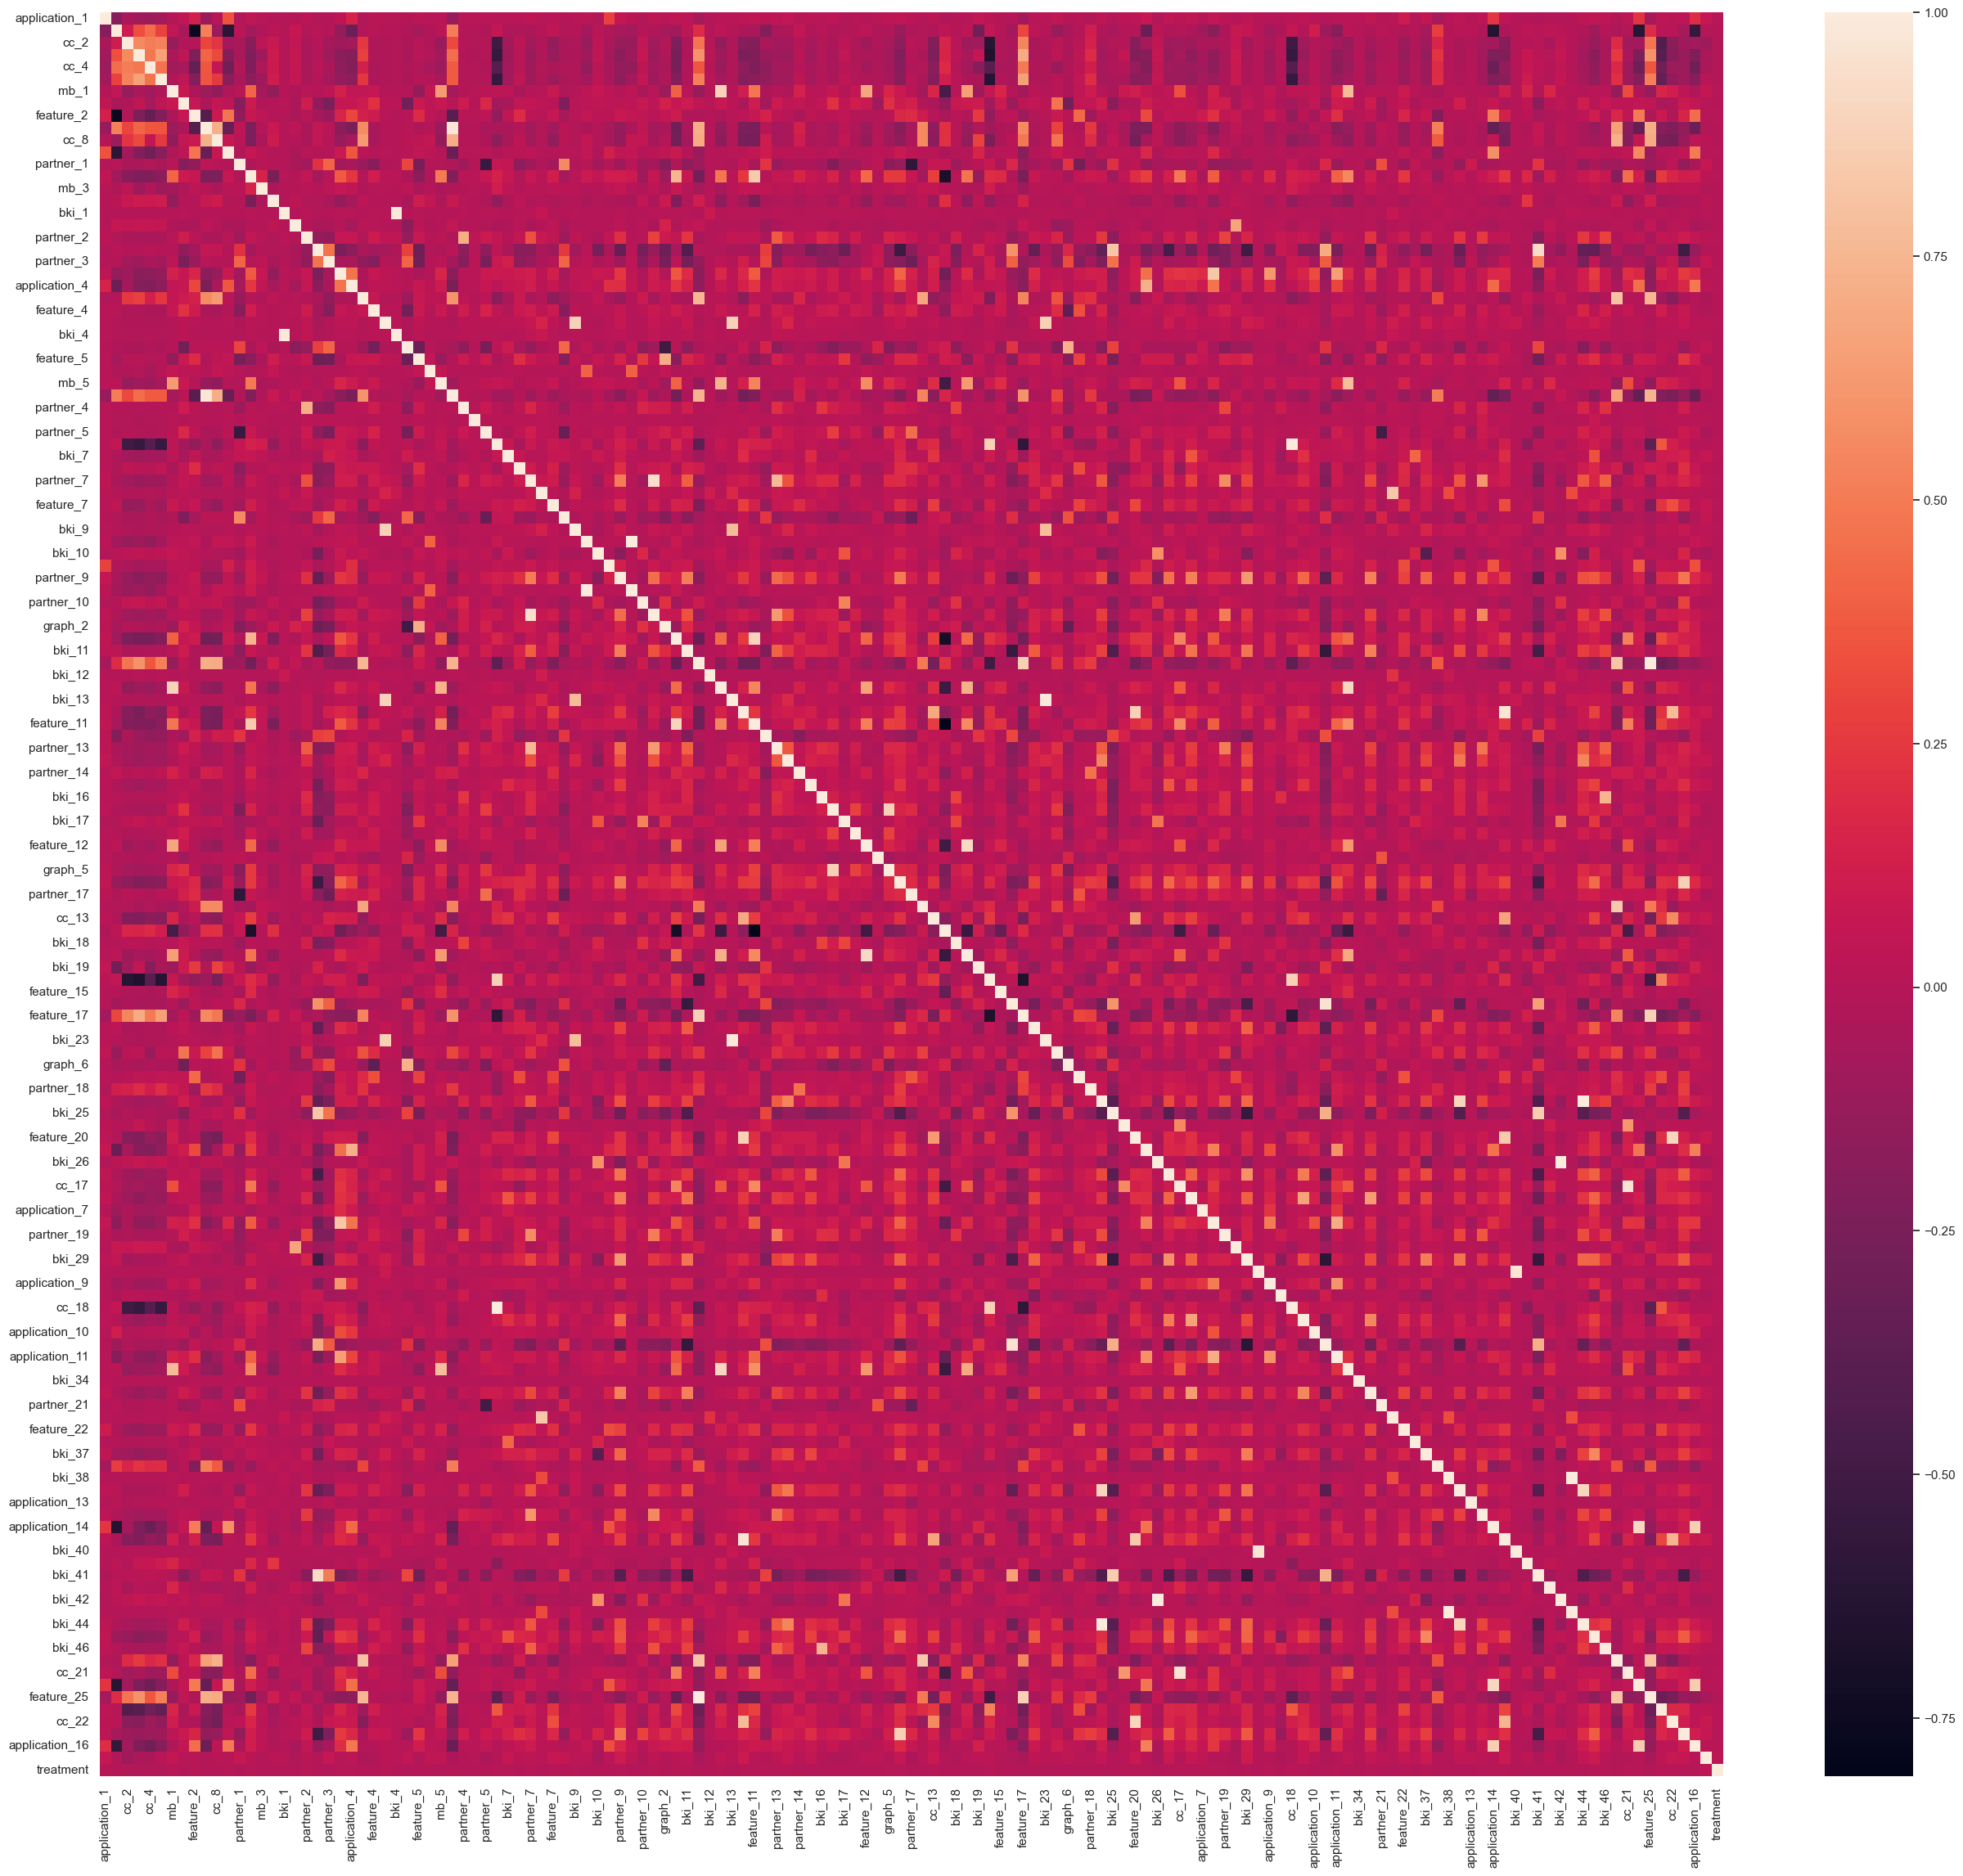

In [27]:
corr_matrix = data.copy()

corr_matrix['cc_4'] = corr_matrix['cc_4'].astype('category')
corr_matrix['cc_4'] = corr_matrix['cc_4'].cat.codes

corr_matrix['cc_2'] = corr_matrix['cc_2'].astype('category')
corr_matrix['cc_2'] = corr_matrix['cc_2'].cat.codes

corr_matrix = corr_matrix.corr()

sns.set(rc={'figure.figsize': (32, 28)})

sns.heatmap(corr_matrix, annot=False)

In [28]:
for i in data.columns:
    if data[i].nunique() < 5:
        print(data[i].unique(), data[i].nunique())
        print(data[i].value_counts())
        print()

[ 1. -1.] 2
cc_1
 1.0    279015
-1.0     18235
Name: count, dtype: int64

[1 0] 2
feature_1
1    170378
0    126872
Name: count, dtype: int64

[-1.  1.] 2
feature_6
-1.0    175616
 1.0    121634
Name: count, dtype: int64

[   0 1890  590  990] 4
cc_10
0       227238
590      64090
1890      5212
990        710
Name: count, dtype: int64

[0 1] 2
cc_11
0    167411
1    129839
Name: count, dtype: int64

[0 1] 2
cc_12
0    167411
1    129839
Name: count, dtype: int64

[ 1. -1.  0.] 3
feature_9
 1.0    188291
-1.0     54546
 0.0     54413
Name: count, dtype: int64

[ 0. -1.  1.] 3
feature_13
 0.0    207353
-1.0     54546
 1.0     35351
Name: count, dtype: int64

[ 0. -1.  1.] 3
bki_19
 0.0    211171
 1.0     54112
-1.0     31967
Name: count, dtype: int64

[0 1] 2
cc_15
0    227176
1     70074
Name: count, dtype: int64

[ 1.   0.   0.2 -1. ] 4
feature_17
 1.0    180463
 0.0    113583
-1.0      3051
 0.2       153
Name: count, dtype: int64

[   0 1890  590  990] 4
cc_18
0       227237
590    

In [30]:
# data = data.drop(columns=['cc_1', 'treatment', 'feature_24', 'feature_6'])
data = data.drop(columns=['treatment'])
test = test[data.drop(columns=['successful_utilization']).columns]

In [31]:
# test = test[data.drop(columns=['successful_utilization']).columns]

## Уменьшим размерность

In [32]:
data['cc_4'] = data['cc_4'].astype('category')
data['cc_4'] = data['cc_4'].cat.codes
data['cc_2'] = data['cc_2'].astype('category')
data['cc_2'] = data['cc_2'].cat.codes

test['cc_4'] = test['cc_4'].astype('category')
test['cc_4'] = test['cc_4'].cat.codes
test['cc_2'] = test['cc_2'].astype('category')
test['cc_2'] = test['cc_2'].cat.codes

# data = pd.get_dummies(data, columns=['cc_4', 'cc_2'], dtype=int)
# test = pd.get_dummies(test, columns=['cc_4', 'cc_2'], dtype=int)

In [33]:
data = reduce_mem_usage(data)
test = reduce_mem_usage(test)

Memory usage of dataframe is 322.60 MB
Memory usage after optimization is: 94.40 MB
Decreased by 70.7%
Memory usage of dataframe is 80.08 MB
Memory usage after optimization is: 23.10 MB
Decreased by 71.2%


In [34]:
data

,application_1,cc_1,cc_2,cc_3,cc_4,feature_1,mb_1,cc_5,feature_2,cc_7,...,bki_46,feature_24,cc_21,application_15,feature_25,feature_26,cc_22,partner_24,application_16,successful_utilization
0,-1.0,1.0,8,123.0,68,1,14.0,147000.0,0.0,0.008659,...,3440894.0,0.0,-1.0,0,1.0,0.0,-1.200195,1.0,0,0
1,-1.0,1.0,5,43.0,1,0,1.0,120000.0,0.0,0.022934,...,124195.0,0.0,1.0,0,1.0,0.0,-1.200195,1.0,0,0
2,0.0,1.0,9,2.0,54,0,-1.0,15000.0,0.0,-1.000000,...,-1.0,-1.0,-1.0,0,-1.0,0.0,-1.200195,1.0,0,1
3,0.0,1.0,2,2.0,20,0,91.0,260000.0,0.0,-1.000000,...,9532268.0,-1.0,1.0,0,-1.0,1.0,-1.200195,1.0,0,0
4,0.0,1.0,8,123.0,68,1,1.0,130000.0,0.0,0.029770,...,0.0,0.0,-1.0,0,1.0,0.0,-1.200195,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297245,-1.0,1.0,8,123.0,68,1,34.0,95000.0,0.0,0.086731,...,569324.5,0.0,-1.0,0,1.0,0.0,-1.200195,1.0,0,1
297246,-1.0,1.0,8,123.0,68,1,1.0,83000.0,0.0,0.025879,...,34332.0,0.0,-1.0,0,1.0,0.0,-1.200195,-1.0,0,0
297247,0.0,1.0,4,2.0,36,0,2.0,170000.0,0.0,-1.000000,...,1165164.0,-1.0,1.0,0,-1.0,0.0,1.000000,1.0,0,0
297248,0.0,1.0,8,123.0,68,1,5.0,15000.0,0.0,0.034546,...,15607111.0,0.0,0.0,0,1.0,0.0,-1.200195,1.0,0,1


In [35]:
test

,application_1,cc_1,cc_2,cc_3,cc_4,feature_1,mb_1,cc_5,feature_2,cc_7,...,bki_45,bki_46,feature_24,cc_21,application_15,feature_25,feature_26,cc_22,partner_24,application_16
0,0.0,1.0,7,0.0,67,0,6.0,0.0,0.0,0.293457,...,1.0,373942.00,0.0,1.0,0,0.0,0.0,-1.200195,1.0,0
1,0.0,1.0,7,0.0,67,0,45.0,0.0,0.0,0.001504,...,0.0,0.00,0.0,0.0,0,0.0,1.0,-1.200195,1.0,0
2,0.0,1.0,2,2.0,10,0,13.0,299000.0,0.0,0.025833,...,1.0,9724333.00,0.0,0.0,0,0.0,0.0,-1.200195,1.0,0
3,0.0,1.0,7,123.0,30,1,158.0,140000.0,0.0,0.004578,...,0.0,0.00,0.0,0.0,0,1.0,0.0,-1.200195,1.0,0
4,0.0,1.0,7,123.0,67,0,36.0,170000.0,0.0,0.034485,...,1.0,2237284.00,0.0,0.0,0,1.0,0.0,-1.200195,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74308,0.0,1.0,7,123.0,18,1,0.0,15000.0,0.0,0.007607,...,2.0,2834099.00,0.0,0.0,0,1.0,0.0,-1.200195,1.0,0
74309,0.0,1.0,7,123.0,67,1,12.0,95000.0,0.0,0.019470,...,0.0,145886.00,0.0,0.0,0,0.0,0.0,-1.200195,1.0,0
74310,0.0,0.0,6,2.0,20,0,5.0,15000.0,0.0,0.000000,...,4.0,5896358.00,0.0,0.0,1,0.0,1.0,-1.200195,1.0,1
74311,0.0,1.0,7,123.0,68,1,52.0,70000.0,0.0,0.001493,...,0.0,5339.00,0.0,0.0,0,1.0,0.0,-1.200195,1.0,0


In [36]:
74313 / 297250

0.2500016820857864

# Обучение модели

## Разделим на треин и тест

In [37]:
X = data.drop(columns=['successful_utilization'])
Y = data['successful_utilization']

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, random_state=seed, test_size=0.1, stratify=Y)

In [38]:
len(X_train), len(X_valid)

(267525, 29725)

## Выбор модели

In [38]:
model_lr = LogisticRegression(random_state=seed, class_weight='balanced')
model_lr.fit(X_train, Y_train)
print('LogisticRegression')

rfc = RandomForestClassifier(random_state=seed, class_weight='balanced')
rfc.fit(X_train, Y_train)
print('RandomForestClassifier')

cat = CatBoostClassifier(use_best_model=True, random_state=seed, verbose=500, auto_class_weights='Balanced')
cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid))
print('CatBoostClassifier')

xgb = XGBClassifier(random_state=seed, class_weight='balanced')
xgb.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], verbose=10)
print('XGBClassifier')

lgbm = LGBMClassifier(random_state=seed, verbose=-1, class_weight='balanced')
lgbm.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)])
print('LGBMClassifier')

LogisticRegression
RandomForestClassifier
Learning rate set to 0.126028
0:	learn: 0.6830170	test: 0.6830966	best: 0.6830966 (0)	total: 250ms	remaining: 4m 10s
500:	learn: 0.5585583	test: 0.5957616	best: 0.5955537 (447)	total: 34.7s	remaining: 34.6s
999:	learn: 0.5254396	test: 0.5982213	best: 0.5955537 (447)	total: 1m 8s	remaining: 0us

bestTest = 0.595553739
bestIteration = 447

Shrink model to first 448 iterations.
CatBoostClassifier
[0]	validation_0-logloss:0.53200
[10]	validation_0-logloss:0.49292
[20]	validation_0-logloss:0.48734
[30]	validation_0-logloss:0.48626
[40]	validation_0-logloss:0.48591
[50]	validation_0-logloss:0.48545
[60]	validation_0-logloss:0.48537
[70]	validation_0-logloss:0.48601
[80]	validation_0-logloss:0.48643
[90]	validation_0-logloss:0.48702
[99]	validation_0-logloss:0.48737
XGBClassifier
LGBMClassifier


In [39]:
evaluate_models(
    models=[model_lr, cat, xgb, lgbm, rfc],
    model_names=['LogisticRegression', 'CatBoostClassifier', 'XGBClassifier',
                 'LGBMClassifier', 'RandomForestClassifier'],
    X=X_valid,
    Y=Y_valid
)

,Model,Accuracy,F1 Score,Recall,Precision,ROC AUC,Gini,Log Loss,AUUQ
0,LogisticRegression,0.572447,0.365850,0.513661,0.284098,0.564797,0.129594,0.672269,0.549256
1,CatBoostClassifier,0.666510,0.490727,0.669189,0.387411,0.736049,0.472098,0.592439,0.679390
2,XGBClassifier,0.770664,0.290265,0.195320,0.564830,0.727394,0.454787,0.487373,0.672813
3,LGBMClassifier,0.653860,0.488288,0.687824,0.378489,0.734341,0.468682,0.597908,0.678092
4,RandomForestClassifier,0.766224,0.117811,0.065013,0.627027,0.707295,0.414590,0.500392,0.657459


## Обучение лучшей модели и выбор параметров

In [39]:
cat = CatBoostClassifier(
    iterations=8192,
    verbose=512,
    loss_function='Logloss',
    eval_metric='AUC',
    use_best_model=True,
    learning_rate=0.008,
    rsm=0.8,
    bagging_temperature=1.0,
    random_seed=seed,
    grow_policy='Depthwise',
    depth=6,
    od_type='Iter',
    od_wait=512
)


cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid))

0:	test: 0.6461096	best: 0.6461096 (0)	total: 373ms	remaining: 50m 54s
512:	test: 0.7240751	best: 0.7240751 (512)	total: 1m 51s	remaining: 27m 44s
1024:	test: 0.7319384	best: 0.7319384 (1024)	total: 3m 48s	remaining: 26m 39s
1536:	test: 0.7356460	best: 0.7356460 (1536)	total: 5m 29s	remaining: 23m 47s
2048:	test: 0.7384251	best: 0.7384311 (2047)	total: 7m 2s	remaining: 21m 6s
2560:	test: 0.7396318	best: 0.7396318 (2560)	total: 8m 30s	remaining: 18m 41s
3072:	test: 0.7402281	best: 0.7402429 (3060)	total: 10m 2s	remaining: 16m 44s
3584:	test: 0.7405131	best: 0.7405340 (3508)	total: 11m 41s	remaining: 15m 1s
4096:	test: 0.7407425	best: 0.7407451 (4095)	total: 13m 1s	remaining: 13m 1s
4608:	test: 0.7405777	best: 0.7408034 (4298)	total: 14m 19s	remaining: 11m 7s
Stopped by overfitting detector  (512 iterations wait)

bestTest = 0.740803369
bestIteration = 4298

Shrink model to first 4299 iterations.


In [40]:
evaluate_models(
    models=[cat],
    model_names=['CatBoostClassifier'],
    X=X_valid,
    Y=Y_valid
)

,Model,Accuracy,F1 Score,Recall,Precision,ROC AUC,Gini,Log Loss,AUUQ
0,CatBoostClassifier,0.776316,0.288801,0.189155,0.610307,0.740803,0.481607,0.477736,0.683003


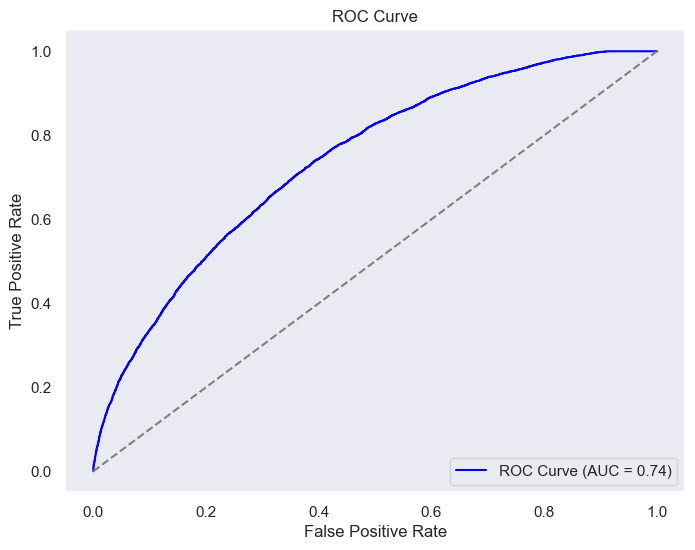

In [41]:
plot_roc_curve(cat, X_valid, Y_valid)

## Submit

In [42]:
submit = pd.read_csv('sub_E.csv').drop(columns=['Unnamed: 0'])
submit['successful_utilization'] = cat.predict_proba(test)[:, 1]
submit

,successful_utilization
0,0.015055
1,0.008465
2,0.290531
3,0.166435
4,0.212495
...,...
74308,0.199003
74309,0.366112
74310,0.036612
74311,0.274003


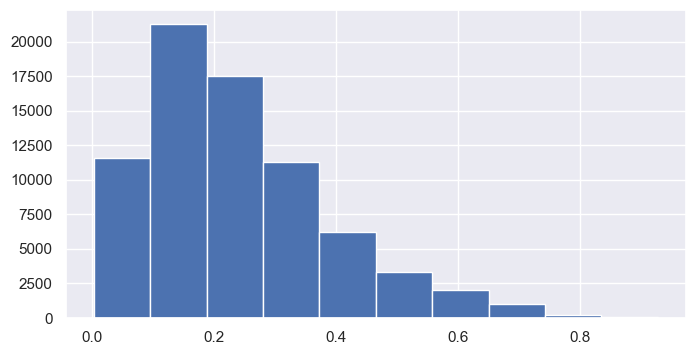

In [43]:
submit['successful_utilization'].hist(figsize=(8, 4));

In [44]:
submit.to_csv('cat_solo.csv')

## Попробуем другую модель

In [46]:
lgbm = LGBMClassifier(
    learning_rate=0.02,
    n_estimators=128,
    reg_alpha=0.6,
    reg_lambda=0.6,
    num_leaves=128,
    max_depth=8,
    min_child_samples=96,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=seed,
    importance_type='gain',
    min_child_weight=4e-3,
    verbose=64
)

lgbm.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], eval_metric='auc')

[LightGBM] [Info] Number of positive: 64235, number of negative: 203290
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.839379
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.256492
[LightGBM] [Debug] init for col-wise cost 0.012182 seconds, init for row-wise cost 0.164492 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23401
[LightGBM] [Info] Number of data points in the train set: 267525, number of used features: 140
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240108 -> initscore=-1.152085
[LightGBM] [Info] Start training from score -1.152085
[LightGBM] [Debug] Trained a tree with leaves = 128 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 128 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 128 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves =

LGBMClassifier(colsample_bytree=0.8, importance_type='gain', learning_rate=0.02,
               max_depth=8, min_child_samples=96, min_child_weight=0.004,
               n_estimators=128, num_leaves=128, random_state=42, reg_alpha=0.6,
               reg_lambda=0.6, subsample=0.8, verbose=64)

In [47]:
evaluate_models(
    models=[lgbm],
    model_names=['LGBMClassifier'],
    X=X_valid,
    Y=Y_valid
)

,Model,Accuracy,F1 Score,Recall,Precision,ROC AUC,Gini,Log Loss,AUUQ
0,LGBMClassifier,0.77238,0.167364,0.095278,0.687563,0.727935,0.45587,0.490845,0.673224


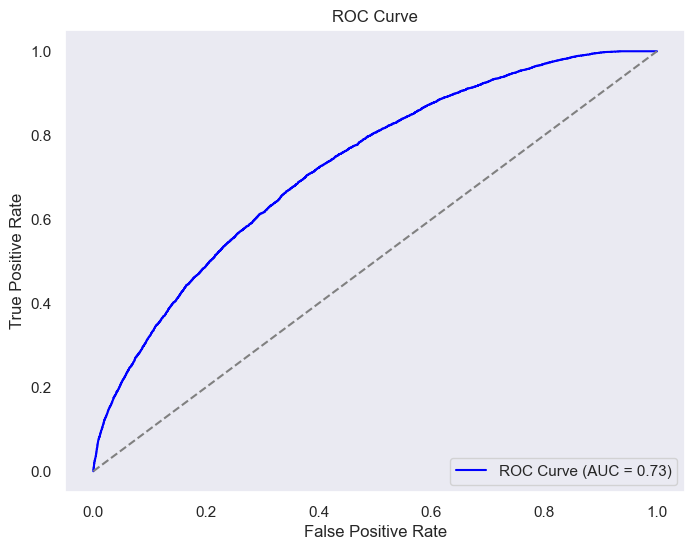

In [48]:
plot_roc_curve(lgbm, X_valid, Y_valid)

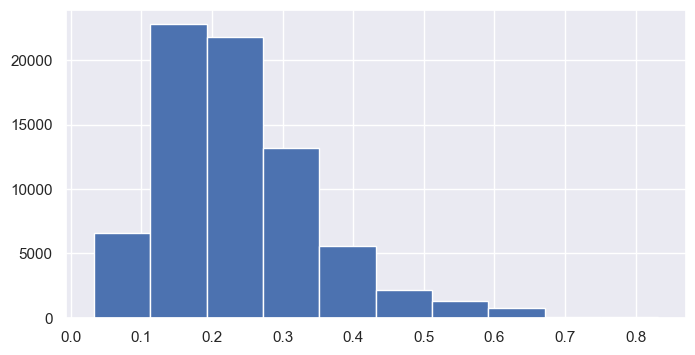

In [49]:
submit = pd.read_csv('sub_E.csv').drop(columns=['Unnamed: 0'])
submit['successful_utilization'] = lgbm.predict_proba(test)[:, 1]
submit['successful_utilization'].hist(figsize=(8, 4));

In [50]:
submit.to_csv('lgbm_solo.csv')

## И еще одну для чистоты эксперимента

In [51]:
xgb = XGBClassifier(
    n_estimators=4096,
    max_depth=6,
    learning_rate=0.04,
    subsample=0.8,
    colsample_bytree=0.7,
    gamma=0.1,
    reg_lambda=1,
    reg_alpha=0.5,
    min_child_weight=1,
    scale_pos_weight=1,
    random_state=seed,
    eval_metric='auc'
)

xgb.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], verbose=128)

[0]	validation_0-auc:0.67804
[128]	validation_0-auc:0.72981
[256]	validation_0-auc:0.73564
[384]	validation_0-auc:0.73749
[512]	validation_0-auc:0.73845
[640]	validation_0-auc:0.73887
[768]	validation_0-auc:0.73892
[896]	validation_0-auc:0.73855
[1024]	validation_0-auc:0.73859
[1152]	validation_0-auc:0.73808
[1280]	validation_0-auc:0.73768
[1408]	validation_0-auc:0.73739
[1536]	validation_0-auc:0.73716
[1664]	validation_0-auc:0.73709
[1792]	validation_0-auc:0.73686
[1920]	validation_0-auc:0.73670
[2048]	validation_0-auc:0.73608
[2176]	validation_0-auc:0.73555
[2304]	validation_0-auc:0.73520
[2432]	validation_0-auc:0.73493
[2560]	validation_0-auc:0.73448
[2688]	validation_0-auc:0.73413
[2816]	validation_0-auc:0.73398
[2944]	validation_0-auc:0.73361
[3072]	validation_0-auc:0.73319
[3200]	validation_0-auc:0.73260
[3328]	validation_0-auc:0.73213
[3456]	validation_0-auc:0.73177
[3584]	validation_0-auc:0.73151
[3712]	validation_0-auc:0.73103
[3840]	validation_0-auc:0.73056
[3968]	validation_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=4096, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [52]:
evaluate_models(
    models=[xgb],
    model_names=['XGBClassifier'],
    X=X_valid,
    Y=Y_valid
)

,Model,Accuracy,F1 Score,Recall,Precision,ROC AUC,Gini,Log Loss,AUUQ
0,XGBClassifier,0.772851,0.308338,0.210873,0.573333,0.729881,0.459761,0.487105,0.674703


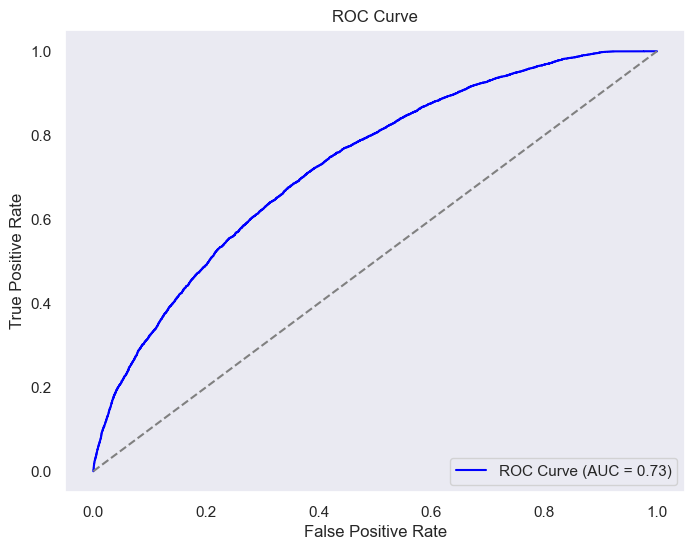

In [53]:
plot_roc_curve(xgb, X_valid, Y_valid)

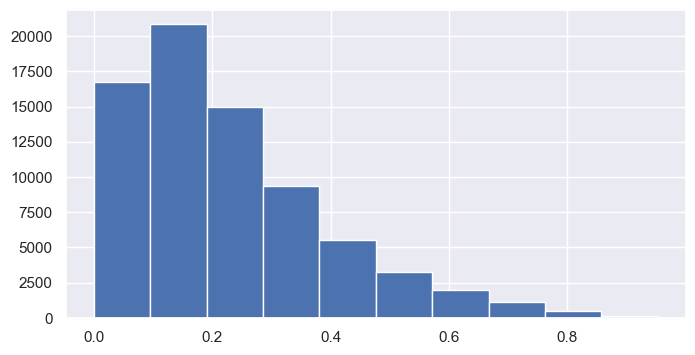

In [54]:
submit = pd.read_csv('sub_E.csv').drop(columns=['Unnamed: 0'])
submit['successful_utilization'] = xgb.predict_proba(test)[:, 1]
submit['successful_utilization'].hist(figsize=(8, 4));

In [55]:
submit.to_csv('xgb_solo.csv')

# Варианты по поднятию точности

## Ensembl

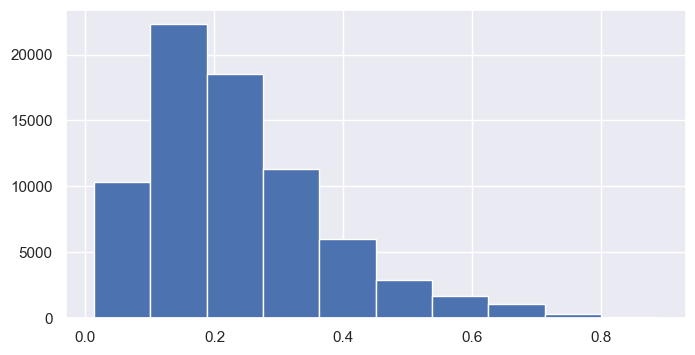

In [56]:
submit = pd.read_csv('sub_E.csv').drop(columns=['Unnamed: 0'])
submit['successful_utilization'] = (lgbm.predict_proba(test)[:, 1] + cat.predict_proba(test)[:, 1] + xgb.predict_proba(test)[:, 1]) / 3
submit['successful_utilization'].hist(figsize=(8, 4));

In [57]:
submit.to_csv('ensemble.csv')

## Blending

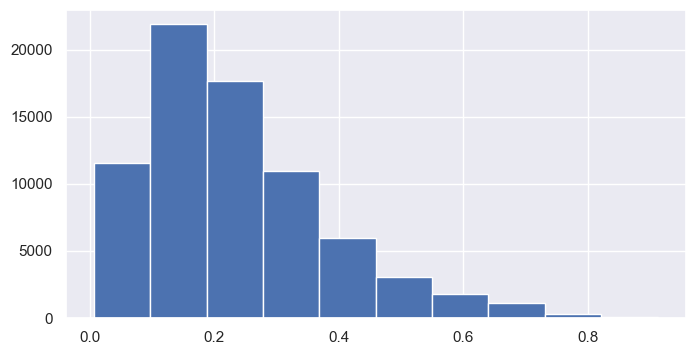

In [58]:
submit = pd.read_csv('sub_E.csv').drop(columns=['Unnamed: 0'])
submit['successful_utilization'] = lgbm.predict_proba(test)[:, 1] * 0.1 + cat.predict_proba(test)[:, 1] * 0.64 + xgb.predict_proba(test)[:, 1] * 0.26
submit['successful_utilization'].hist(figsize=(8, 4));
submit.to_csv('blending.csv')

In [59]:
submit.to_csv('blending.csv')

## Standart data

In [60]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [61]:
X = data.drop(columns=['successful_utilization'])
Y = data['successful_utilization']

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, random_state=seed, test_size=0.1, stratify=Y)

X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

## Cat

In [62]:
cat = CatBoostClassifier(
    iterations=8192,
    verbose=512,
    loss_function='Logloss',
    eval_metric='AUC',
    use_best_model=True,
    learning_rate=0.008,
    rsm=0.8,
    bagging_temperature=1.0,
    random_seed=seed,
    grow_policy='Depthwise',
    depth=6,
    od_type='Iter',
    od_wait=512
)


cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid))

0:	test: 0.6191084	best: 0.6191084 (0)	total: 193ms	remaining: 26m 17s
512:	test: 0.7246640	best: 0.7246640 (512)	total: 1m 55s	remaining: 28m 51s
1024:	test: 0.7320245	best: 0.7320245 (1024)	total: 3m 48s	remaining: 26m 37s
1536:	test: 0.7352115	best: 0.7352115 (1536)	total: 5m 27s	remaining: 23m 36s
2048:	test: 0.7374418	best: 0.7374434 (2047)	total: 7m 7s	remaining: 21m 21s
2560:	test: 0.7386556	best: 0.7386577 (2558)	total: 8m 46s	remaining: 19m 18s
3072:	test: 0.7392344	best: 0.7392453 (3033)	total: 10m 34s	remaining: 17m 36s
3584:	test: 0.7394975	best: 0.7395037 (3583)	total: 12m 15s	remaining: 15m 44s
4096:	test: 0.7397840	best: 0.7397942 (4044)	total: 14m 11s	remaining: 14m 11s
Stopped by overfitting detector  (512 iterations wait)

bestTest = 0.7397942043
bestIteration = 4044

Shrink model to first 4045 iterations.


In [63]:
evaluate_models(
    models=[cat],
    model_names=['CatBoostClassifier'],
    X=X_valid,
    Y=Y_valid
)

,Model,Accuracy,F1 Score,Recall,Precision,ROC AUC,Gini,Log Loss,AUUQ
0,CatBoostClassifier,0.776653,0.287126,0.187334,0.61443,0.739794,0.479588,0.478778,0.682236


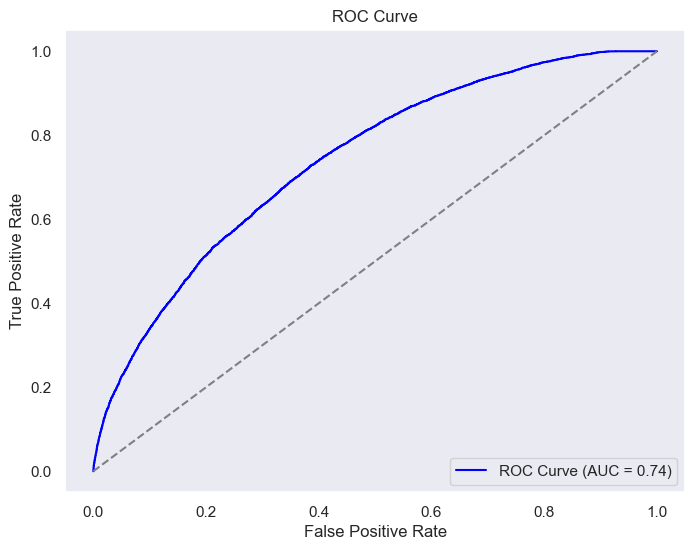

In [64]:
plot_roc_curve(cat, X_valid, Y_valid)

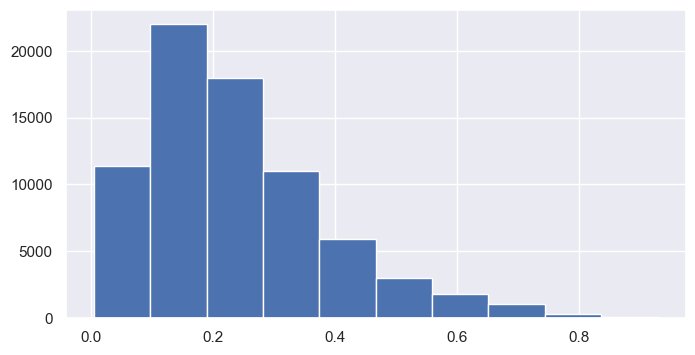

In [65]:
submit = pd.read_csv('sub_E.csv').drop(columns=['Unnamed: 0'])
submit['successful_utilization'] = cat.predict_proba(scaler.transform(test))[:, 1]
submit['successful_utilization'].hist(figsize=(8, 4));

In [66]:
submit.to_csv('cat_solo_minmax_scaler.csv')

## LGBM

In [67]:
lgbm = LGBMClassifier(
    learning_rate=0.02,
    n_estimators=1512,
    reg_alpha=0.6,
    reg_lambda=0.6,
    num_leaves=128,
    max_depth=8,
    min_child_samples=96,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=seed,
    importance_type='gain',
    min_child_weight=4e-3,
    verbose=64
)

lgbm.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], eval_metric='auc')

[LightGBM] [Info] Number of positive: 64235, number of negative: 203290
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.839379
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.254101
[LightGBM] [Debug] init for col-wise cost 0.019022 seconds, init for row-wise cost 0.161210 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.200243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23393
[LightGBM] [Info] Number of data points in the train set: 267525, number of used features: 140
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240108 -> initscore=-1.152085
[LightGBM] [Info] Start training from score -1.152085
[LightGBM] [Debug] Trained a tree with leaves = 128 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 128 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 128 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves =

LGBMClassifier(colsample_bytree=0.8, importance_type='gain', learning_rate=0.02,
               max_depth=8, min_child_samples=96, min_child_weight=0.004,
               n_estimators=1512, num_leaves=128, random_state=42,
               reg_alpha=0.6, reg_lambda=0.6, subsample=0.8, verbose=64)

In [68]:
evaluate_models(
    models=[lgbm],
    model_names=['LGBMClassifier'],
    X=X_valid,
    Y=Y_valid
)

,Model,Accuracy,F1 Score,Recall,Precision,ROC AUC,Gini,Log Loss,AUUQ
0,LGBMClassifier,0.775442,0.293127,0.193919,0.600173,0.738202,0.476405,0.47937,0.681027


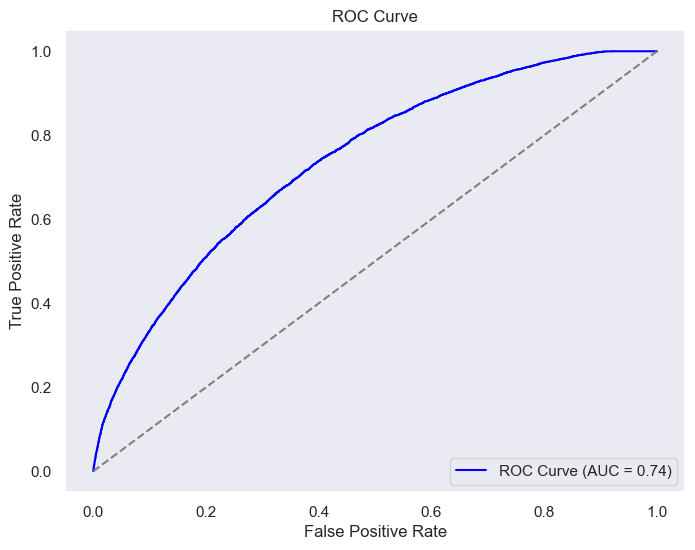

In [69]:
plot_roc_curve(lgbm, X_valid, Y_valid)

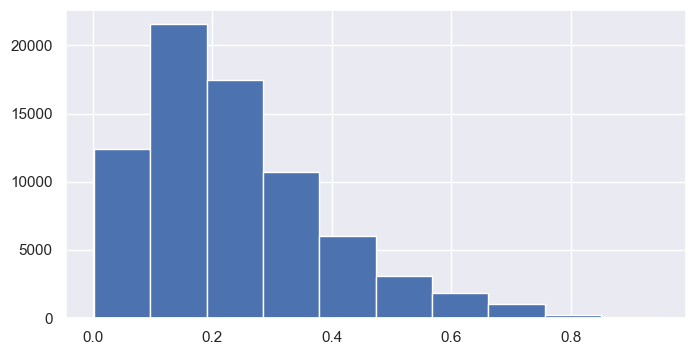

In [70]:
submit = pd.read_csv('sub_E.csv').drop(columns=['Unnamed: 0'])
submit['successful_utilization'] = lgbm.predict_proba(scaler.transform(test))[:, 1]
submit['successful_utilization'].hist(figsize=(8, 4));

In [71]:
submit.to_csv('lgbm_solo_minmax_scaler.csv')

## XGB

In [72]:
xgb = XGBClassifier(
    n_estimators=3000,
    max_depth=6,
    learning_rate=0.04,
    subsample=0.8,
    colsample_bytree=0.7,
    gamma=0.1,
    reg_lambda=1,
    reg_alpha=0.5,
    min_child_weight=1,
    scale_pos_weight=1,
    random_state=seed,
    eval_metric='auc'
)

xgb.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], verbose=128)

[0]	validation_0-auc:0.67804
[128]	validation_0-auc:0.73049
[256]	validation_0-auc:0.73582
[384]	validation_0-auc:0.73773
[512]	validation_0-auc:0.73877
[640]	validation_0-auc:0.73891
[768]	validation_0-auc:0.73876
[896]	validation_0-auc:0.73843
[1024]	validation_0-auc:0.73805
[1152]	validation_0-auc:0.73780
[1280]	validation_0-auc:0.73759
[1408]	validation_0-auc:0.73692
[1536]	validation_0-auc:0.73655
[1664]	validation_0-auc:0.73608
[1792]	validation_0-auc:0.73567
[1920]	validation_0-auc:0.73538
[2048]	validation_0-auc:0.73504
[2176]	validation_0-auc:0.73484
[2304]	validation_0-auc:0.73454
[2432]	validation_0-auc:0.73415
[2560]	validation_0-auc:0.73408
[2688]	validation_0-auc:0.73378
[2816]	validation_0-auc:0.73347
[2944]	validation_0-auc:0.73295
[2999]	validation_0-auc:0.73283


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=3000, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [73]:
evaluate_models(
    models=[xgb],
    model_names=['XGBClassifier'],
    X=X_valid,
    Y=Y_valid
)

,Model,Accuracy,F1 Score,Recall,Precision,ROC AUC,Gini,Log Loss,AUUQ
0,XGBClassifier,0.77423,0.306643,0.207931,0.583792,0.732834,0.465668,0.483959,0.676947


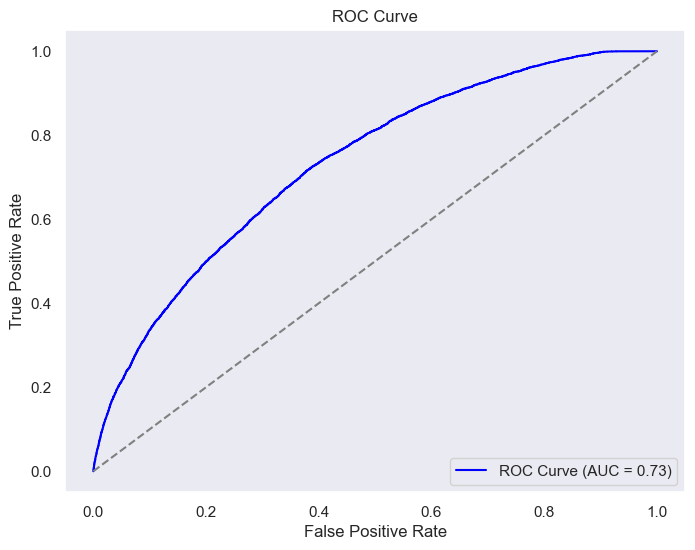

In [74]:
plot_roc_curve(xgb, X_valid, Y_valid)

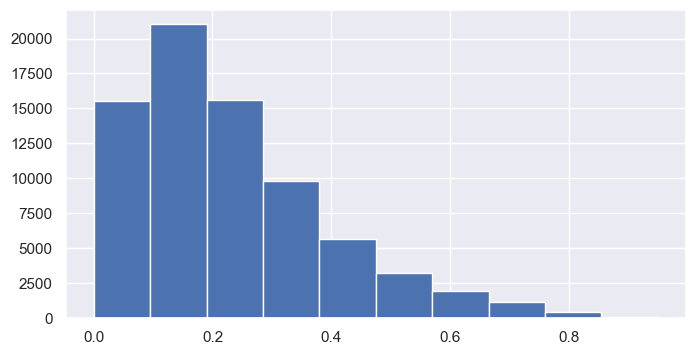

In [75]:
submit = pd.read_csv('sub_E.csv').drop(columns=['Unnamed: 0'])
submit['successful_utilization'] = xgb.predict_proba(scaler.transform(test))[:, 1]
submit['successful_utilization'].hist(figsize=(8, 4));

In [76]:
submit.to_csv('xgb_solo_minmax_scaler.csv')

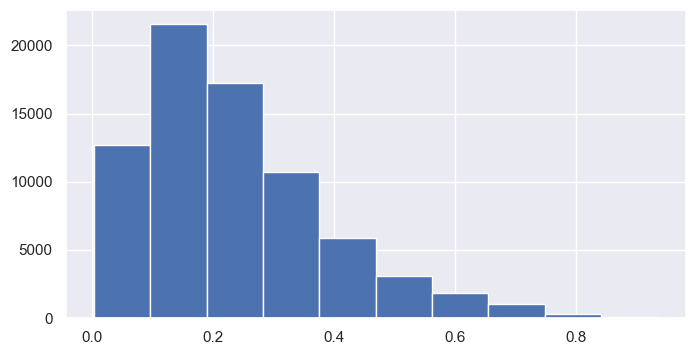

In [77]:
submit = pd.read_csv('sub_E.csv').drop(columns=['Unnamed: 0'])
submit['successful_utilization'] = (lgbm.predict_proba(scaler.transform(test))[:, 1] + cat.predict_proba(scaler.transform(test))[:, 1] + xgb.predict_proba(scaler.transform(test))[:, 1]) / 3
submit['successful_utilization'].hist(figsize=(8, 4));
submit.to_csv('ensembl_minmax_scaler.csv')

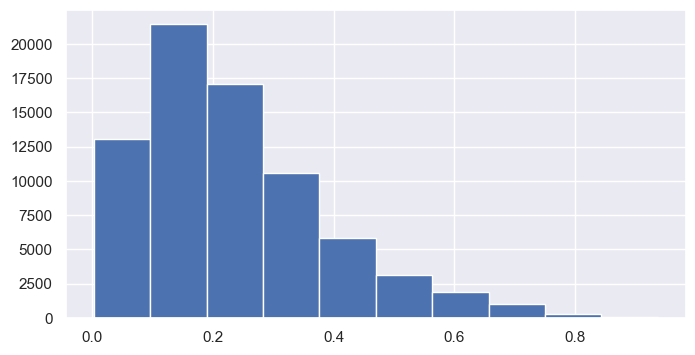

In [78]:
submit = pd.read_csv('sub_E.csv').drop(columns=['Unnamed: 0'])
submit['successful_utilization'] = lgbm.predict_proba(scaler.transform(test))[:, 1] * 0.4 + cat.predict_proba(scaler.transform(test))[:, 1] * 0.2 + xgb.predict_proba(scaler.transform(test))[:, 1] * 0.4
submit['successful_utilization'].hist(figsize=(8, 4));
submit.to_csv('blending_minmax_scaler.csv')

## Resempl

In [79]:
X = data.drop(columns=['successful_utilization'])
Y = data['successful_utilization']

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, random_state=seed, test_size=0.1, stratify=Y)

In [80]:
from imblearn.over_sampling import ADASYN


adasyn = ADASYN(sampling_strategy='minority', random_state=seed)
X_train, Y_train = adasyn.fit_resample(X_train, Y_train)

## Cat

In [81]:
cat = CatBoostClassifier(
    iterations=8192,
    verbose=512,
    loss_function='Logloss',
    eval_metric='AUC',
    use_best_model=True,
    learning_rate=0.008,
    rsm=0.8,
    bagging_temperature=1.0,
    random_seed=seed,
    grow_policy='Depthwise',
    depth=6,
    od_type='Iter',
    od_wait=512
)


cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid))

0:	test: 0.6327362	best: 0.6327362 (0)	total: 224ms	remaining: 30m 31s
512:	test: 0.7188245	best: 0.7188245 (512)	total: 1m 53s	remaining: 28m 18s
1024:	test: 0.7280875	best: 0.7280875 (1024)	total: 3m 50s	remaining: 26m 54s
1536:	test: 0.7320678	best: 0.7320678 (1536)	total: 5m 48s	remaining: 25m 9s
2048:	test: 0.7347709	best: 0.7347709 (2048)	total: 7m 41s	remaining: 23m 3s
2560:	test: 0.7361038	best: 0.7361038 (2560)	total: 9m 34s	remaining: 21m 3s
3072:	test: 0.7367521	best: 0.7367651 (3055)	total: 11m 27s	remaining: 19m 5s
3584:	test: 0.7372171	best: 0.7372171 (3584)	total: 13m 18s	remaining: 17m 6s
4096:	test: 0.7374251	best: 0.7374401 (3847)	total: 15m 7s	remaining: 15m 7s
4608:	test: 0.7375955	best: 0.7376022 (4601)	total: 16m 55s	remaining: 13m 9s
Stopped by overfitting detector  (512 iterations wait)

bestTest = 0.7376022138
bestIteration = 4601

Shrink model to first 4602 iterations.


In [82]:
evaluate_models(
    models=[cat],
    model_names=['CatBoostClassifier'],
    X=X_valid,
    Y=Y_valid
)

,Model,Accuracy,F1 Score,Recall,Precision,ROC AUC,Gini,Log Loss,AUUQ
0,CatBoostClassifier,0.775038,0.294248,0.19532,0.596236,0.737602,0.475204,0.480212,0.680571


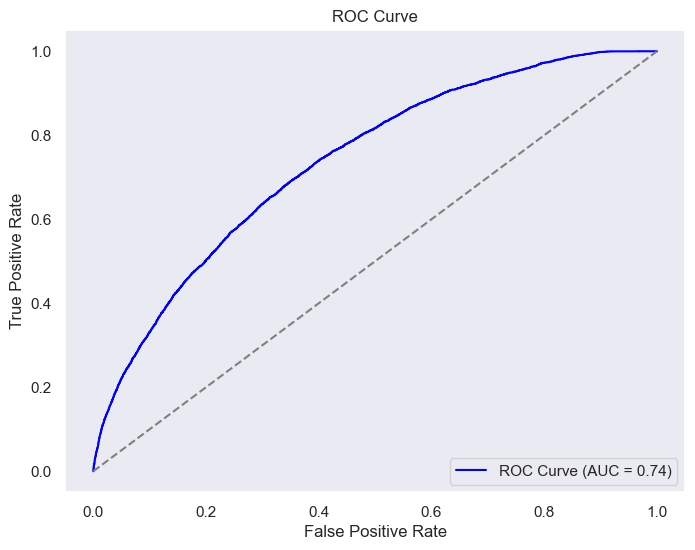

In [83]:
plot_roc_curve(cat, X_valid, Y_valid)

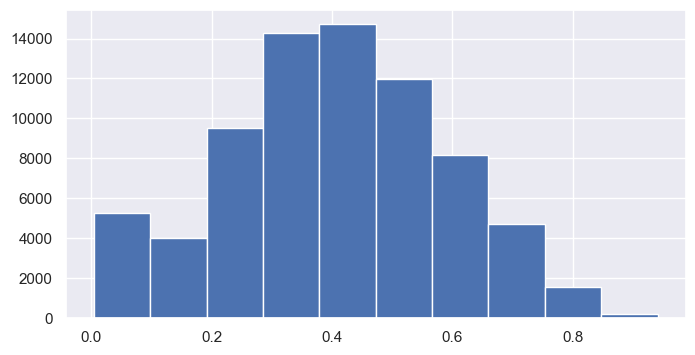

In [84]:
submit = pd.read_csv('sub_E.csv').drop(columns=['Unnamed: 0'])
submit['successful_utilization'] = cat.predict_proba(test)[:, 1]
submit['successful_utilization'].hist(figsize=(8, 4));
submit.to_csv('cat_solo_adasyn.csv')

## LGBM

In [85]:
lgbm = LGBMClassifier(
    learning_rate=0.02,
    n_estimators=1512,
    reg_alpha=0.6,
    reg_lambda=0.6,
    num_leaves=128,
    max_depth=8,
    min_child_samples=96,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=seed,
    importance_type='gain',
    min_child_weight=4e-3,
    verbose=64
)

lgbm.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], eval_metric='auc')

[LightGBM] [Info] Number of positive: 199081, number of negative: 203290
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.803583
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.233663
[LightGBM] [Debug] init for col-wise cost 0.017488 seconds, init for row-wise cost 0.088007 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32150
[LightGBM] [Info] Number of data points in the train set: 402371, number of used features: 140
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494770 -> initscore=-0.020922
[LightGBM] [Info] Start training from score -0.020922
[LightGBM] [Debug] Trained a tree with leaves = 128 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 128 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 128 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves 

LGBMClassifier(colsample_bytree=0.8, importance_type='gain', learning_rate=0.02,
               max_depth=8, min_child_samples=96, min_child_weight=0.004,
               n_estimators=1512, num_leaves=128, random_state=42,
               reg_alpha=0.6, reg_lambda=0.6, subsample=0.8, verbose=64)

In [86]:
evaluate_models(
    models=[lgbm],
    model_names=['LGBMClassifier'],
    X=X_valid,
    Y=Y_valid
)

,Model,Accuracy,F1 Score,Recall,Precision,ROC AUC,Gini,Log Loss,AUUQ
0,LGBMClassifier,0.775172,0.29198,0.193078,0.59861,0.738444,0.476888,0.479124,0.68121


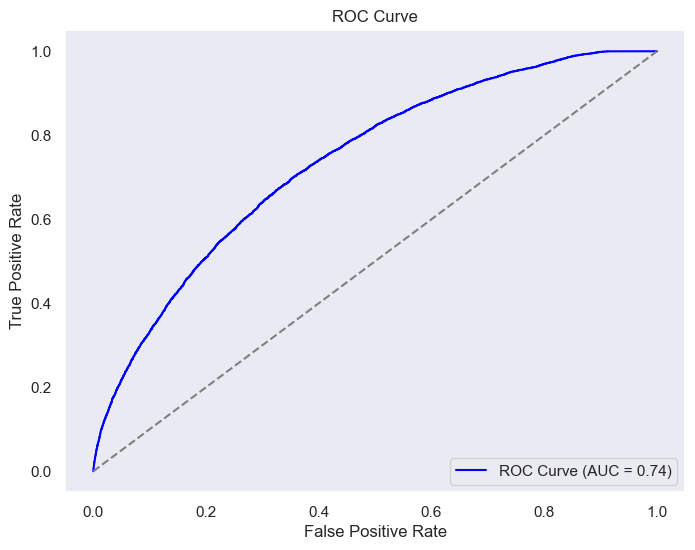

In [87]:
plot_roc_curve(lgbm, X_valid, Y_valid)

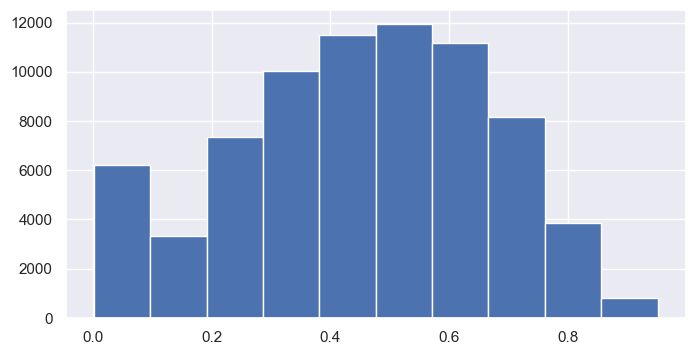

In [88]:
submit = pd.read_csv('sub_E.csv').drop(columns=['Unnamed: 0'])
submit['successful_utilization'] = lgbm.predict_proba(test)[:, 1]
submit['successful_utilization'].hist(figsize=(8, 4));
submit.to_csv('lgbm_solo_adasyn.csv')

## XGB

In [89]:
xgb = XGBClassifier(
    n_estimators=4096,
    max_depth=6,
    learning_rate=0.04,
    subsample=0.8,
    colsample_bytree=0.7,
    gamma=0.1,
    reg_lambda=1,
    reg_alpha=0.5,
    min_child_weight=1,
    scale_pos_weight=1,
    random_state=seed,
    eval_metric='auc'
)

xgb.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], verbose=128)

[0]	validation_0-auc:0.64283
[128]	validation_0-auc:0.71470
[256]	validation_0-auc:0.72927
[384]	validation_0-auc:0.73375
[512]	validation_0-auc:0.73594
[640]	validation_0-auc:0.73700
[768]	validation_0-auc:0.73743
[896]	validation_0-auc:0.73780
[1024]	validation_0-auc:0.73817
[1152]	validation_0-auc:0.73798
[1280]	validation_0-auc:0.73779
[1408]	validation_0-auc:0.73745
[1536]	validation_0-auc:0.73728
[1664]	validation_0-auc:0.73678
[1792]	validation_0-auc:0.73641
[1920]	validation_0-auc:0.73635
[2048]	validation_0-auc:0.73622
[2176]	validation_0-auc:0.73561
[2304]	validation_0-auc:0.73502
[2432]	validation_0-auc:0.73476
[2560]	validation_0-auc:0.73466
[2688]	validation_0-auc:0.73448
[2816]	validation_0-auc:0.73416
[2944]	validation_0-auc:0.73381
[3072]	validation_0-auc:0.73374
[3200]	validation_0-auc:0.73306
[3328]	validation_0-auc:0.73252
[3456]	validation_0-auc:0.73207
[3584]	validation_0-auc:0.73178
[3712]	validation_0-auc:0.73127
[3840]	validation_0-auc:0.73079
[3968]	validation_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=4096, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [90]:
evaluate_models(
    models=[xgb],
    model_names=['XGBClassifier'],
    X=X_valid,
    Y=Y_valid
)

,Model,Accuracy,F1 Score,Recall,Precision,ROC AUC,Gini,Log Loss,AUUQ
0,XGBClassifier,0.77386,0.315897,0.217458,0.577166,0.730297,0.460594,0.486293,0.675019


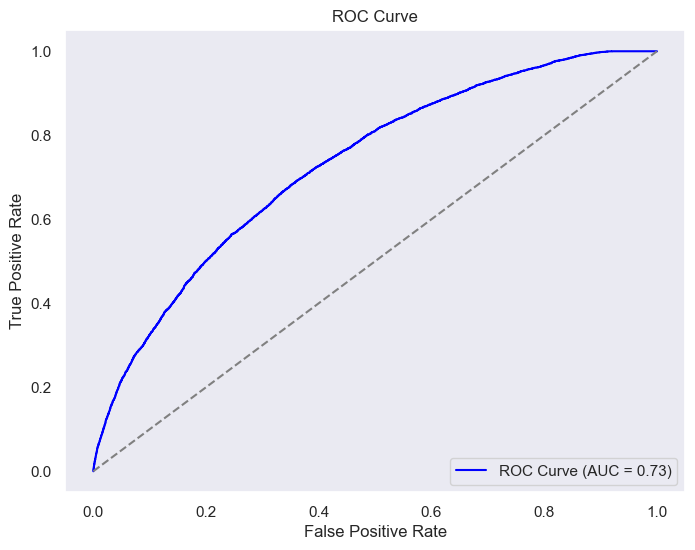

In [91]:
plot_roc_curve(xgb, X_valid, Y_valid)

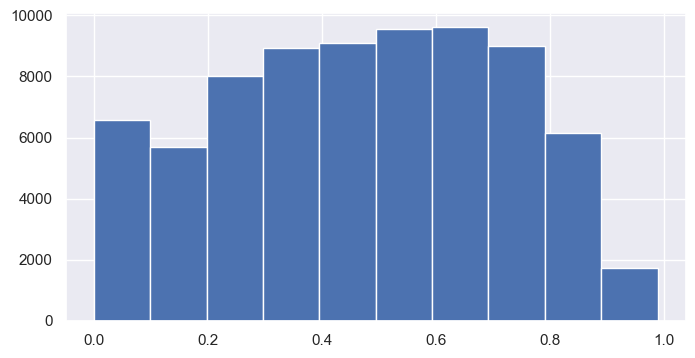

In [92]:
submit = pd.read_csv('sub_E.csv').drop(columns=['Unnamed: 0'])
submit['successful_utilization'] = xgb.predict_proba(test)[:, 1]
submit['successful_utilization'].hist(figsize=(8, 4));
submit.to_csv('xgb_solo_adasyn.csv')

## Features Selection